# Plots in the appendix

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import scipy.stats as stats

# Disable warnings
warnings.filterwarnings('ignore')

In [2]:
# General settings
figure_path = "./figures/appendix/"

# Seaborn settings
sns.set_palette(sns.color_palette("magma"))
sns.set_style("ticks")
sns.set_style({'font.family': 'Lato'})
sns.set_context("paper", font_scale = 1.8)

## Figure 7

Using Res18 order


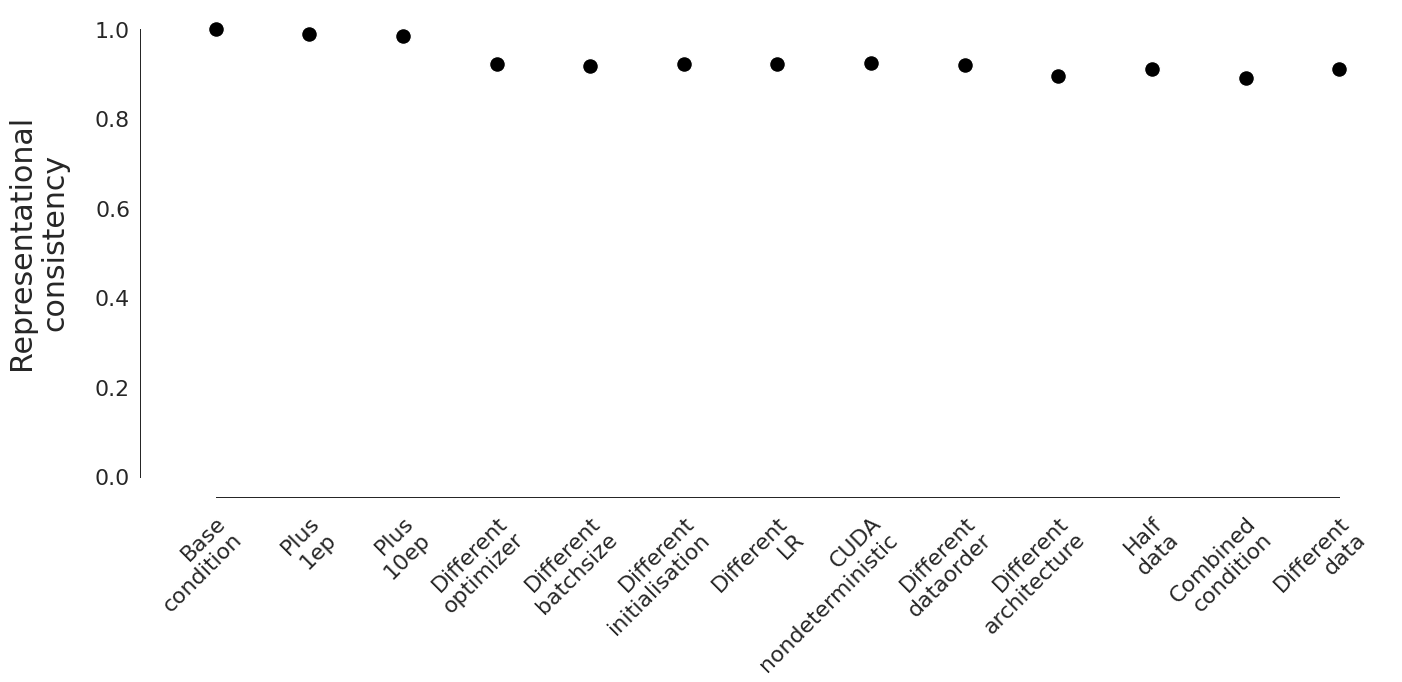

In [3]:
# Set base network
base_network = "Res18"
folder_name = f"results/{base_network}/"

# Load ordering of conditions as it is in figure 1
res18_order = np.load(folder_name + f"{base_network}_main_order.npy")

# Load RSA array (Construction of the array can be seen in rsa_note.ipynb)
rsa = np.load(folder_name + f'{base_network}_rsa_corrs.npy')

# Configure labels
main_array = np.load(f"results/{base_network}/{base_network}_main_array.npy", allow_pickle=True)
labels = main_array[0, res18_order, 0]
labels_correct = np.empty(len(labels), dtype=object)
for ind, label in enumerate(labels):
    labels_correct[ind] = label[1:]
    
# Load main plot function from analysis_helpers
from scripts.analysis_helpers import main_plot_acc

# Make plot and save it
main_plot_acc(rsa, 0, figure_path, base_network, labels_correct, "Representational\nconsistency", res18_order)
plt.savefig(figure_path + 'figure_7.png', dpi=300, bbox_inches='tight')

## Figure 8

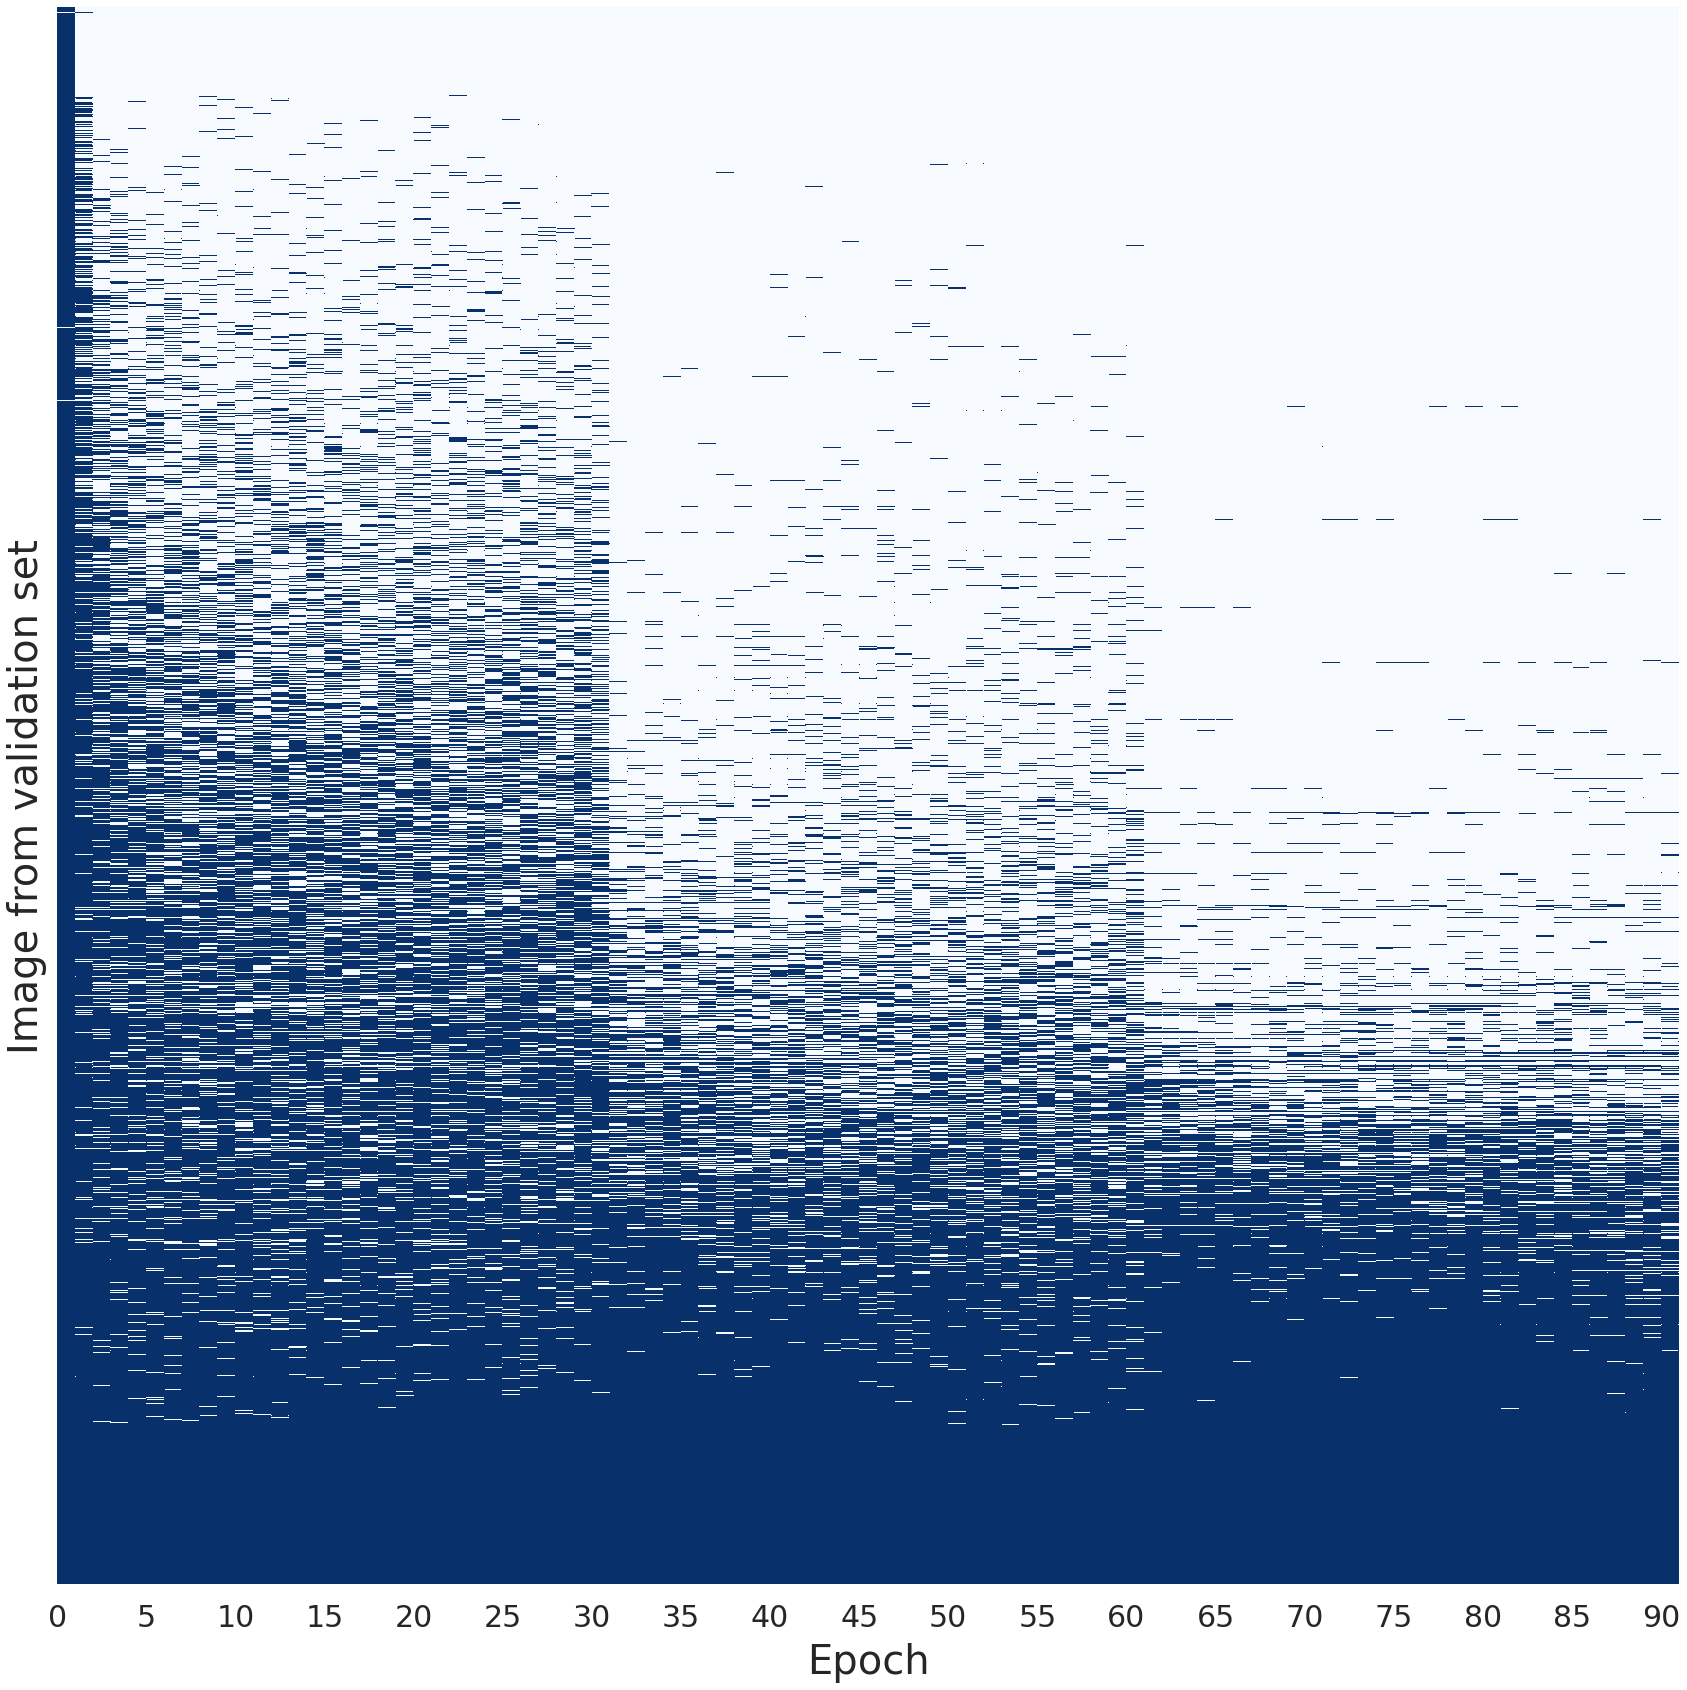

In [4]:
# Load main array
decisions = np.load(folder_name + f"{base_network}_decisions_correct.npy", allow_pickle=True)
decisions = decisions[0]

# Set colormap and general figure setting
col_map = "Blues_r"      
plt.figure(figsize=(24, 24))

# Plot decisions
mean_order = np.flip((np.mean(decisions, axis=1)).argsort())
sns.heatmap(decisions[mean_order, :], cmap=col_map, cbar=False, yticklabels=False)

# Figure aesthetics and labels
sns.despine(top=True, right=True, left=True, offset=10, trim=True)
plt.xticks(np.arange(0, decisions.shape[1], 5), labels=np.arange(0, decisions.shape[1], 5), fontsize=30)
plt.xlabel("Epoch", fontsize=40, labelpad=10)
plt.ylabel("Image from validation set", fontsize=40, labelpad=10)
plt.tight_layout()
    
# Save figure
plt.savefig(figure_path + 'figure_8.png', dpi=150, bbox_inches='tight')

## Figure 9

In [5]:
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn 
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from numpy import genfromtxt

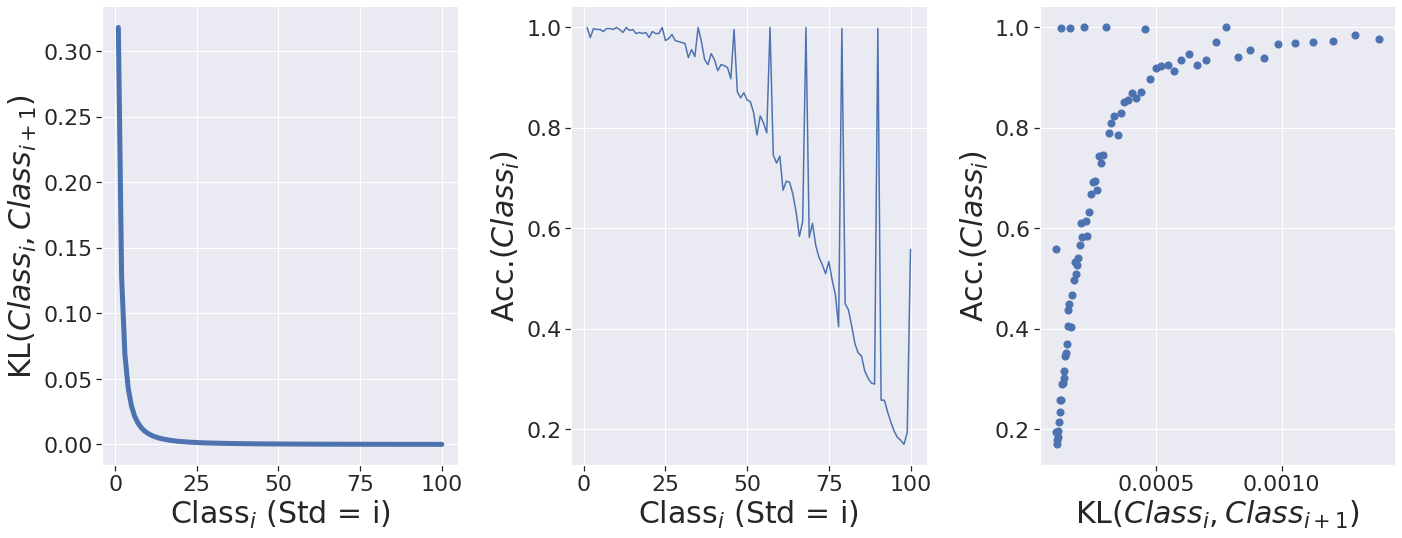

In [6]:
# Load file and set variables
base = torch.load('results/GAUSSIAN_EP30.txt',map_location=torch.device('cpu'))
label = base[2].detach().numpy()
base = base[1].detach().numpy()
correctResponse = label == base
correctResponse = np.asarray(correctResponse)

# Get class accuracies
classAcc = []
for i in range(100):
    classAcc.append(np.mean(correctResponse[i*500:(i+1)*500]))
    
# Compute KL divergence
x = np.linspace(1,100,100)
y = np.linspace(2,101,100)  
KL = np.log(y/x) + ((x**2)/(2* y **2)) -(1/2)

# Make figures
plt.figure(figsize=(20,8))
ax = plt.subplot(131)
plt.plot(x,KL,linewidth=5)
plt.xlabel(r'Class$_i$ (Std = i)', fontsize=30)
plt.ylabel(r'KL$(Class_i,Class_{i+1})$', fontsize=30)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax = plt.subplot(132)
plt.plot(x,classAcc)
plt.xlabel(r'Class$_i$ (Std = i)', fontsize=30)
plt.ylabel(r'Acc.$(Class_i)$', fontsize=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax = plt.subplot(133)
plt.scatter(KL[25:100],classAcc[25:100], s = 50)
plt.xlabel(r'KL$(Class_i,Class_{i+1})$', fontsize=30)
plt.ylabel(r'Acc.$(Class_i)$', fontsize=30)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tight_layout()
plt.savefig(figure_path + 'figure_9.png', dpi=150, bbox_inches='tight')

## Figure 10

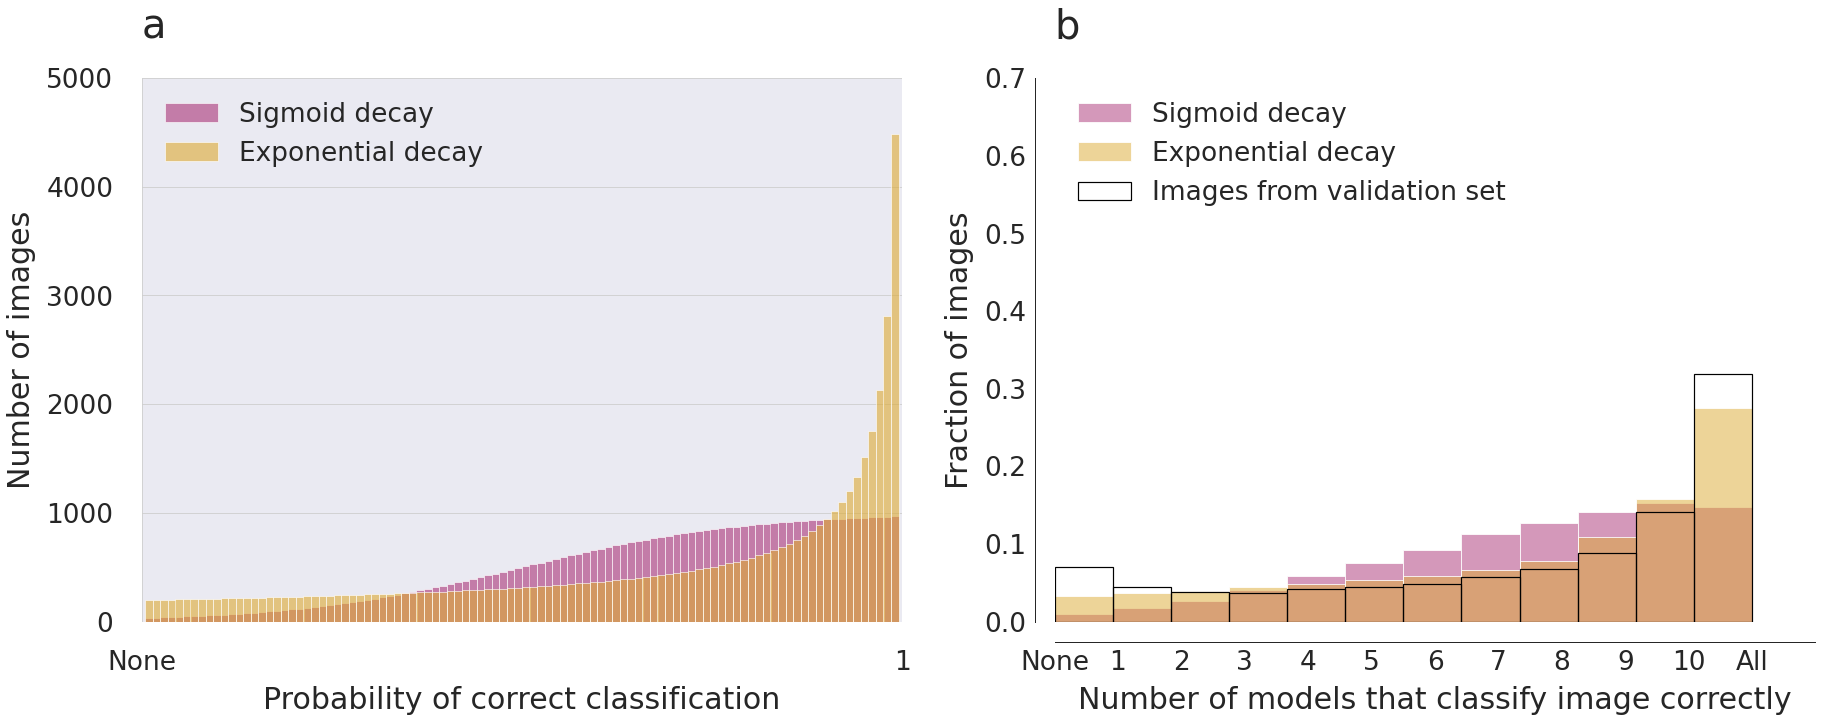

In [7]:
# Import and set beta function parameters
from scipy.stats import beta
from numpy.random import default_rng

# Set folder names
base_network = "Rebuttal"
folder_name = f"results/{base_network}/"

# Get numpy rng
np.random.seed(1312)
rng = default_rng()

# Load data
mean_decisions_correct = np.load(folder_name + f"{base_network}_mean_decisions_correct.npy")

# Set beta parameters
betaA = 1
betaB = 0.32

# Set sigmoid function parameters
scale = -6.85
num_models = 11
ep = 0

def logFunction(x,w):
    return 1/(1 + np.exp(w*(x-0.5)))

# Make vector of probabilities from 0.01 to 1.00 in 0.01 steps
probabilities = np.linspace(0.01, 0.99, 100)

# Make vector for which we sample how many items have this probability
images_correct_beta = np.zeros(len(probabilities))
images_correct_sigmoid = np.zeros(len(probabilities))

# Loop through probabilities and sample how many images are at this probability
n_all_beta = 0
n_all_sigmoid = 0
prob_count_beta = 0
prob_count_sigmoid = 0

for ind, prob in enumerate(probabilities):
    
    # For beta function
    images_correct_beta[ind] = beta.pdf(prob, betaA, betaB)
    prob_count_beta += beta.pdf(prob, betaA, betaB) * prob
    n_all_beta += beta.pdf(prob,betaA,betaB) 
    
    # For sigmoid function
    images_correct_sigmoid[ind] = logFunction(prob,scale)
    prob_count_sigmoid += logFunction(prob,scale) * prob
    n_all_sigmoid += logFunction(prob,scale)

# Multiply with multiplication factor
images_correct_beta = images_correct_beta * (50000 / n_all_beta)
images_correct_sigmoid = images_correct_sigmoid * (50000 / n_all_sigmoid)

# Loop through probabilities and sample how many images are at this probability
s_beta = []
s_sigmoid = []

for ind, prob in enumerate(probabilities):
    if ind == 0:
        s_beta = np.array(rng.binomial(num_models, prob, int(images_correct_beta[ind])))
        s_sigmoid = np.array(rng.binomial(num_models, prob, int(images_correct_sigmoid[ind])))
    else:
        s_beta = np.concatenate((s_beta, np.array(rng.binomial(num_models, prob, int(images_correct_beta[ind])))))
        s_sigmoid = np.concatenate((s_sigmoid, 
                                    np.array(rng.binomial(num_models, prob, int(images_correct_sigmoid[ind])))))
        
# Make mean decisions correct with binomial observer figure
s_binom = rng.binomial(num_models, np.mean(mean_decisions_correct[:, ep]), mean_decisions_correct.shape[0])

# Get counts
counts_data = np.histogram(mean_decisions_correct[:, ep] * num_models, bins=np.arange(0, num_models+2))
counts_binom = np.histogram(s_binom, bins=np.arange(0, num_models+2))
counts_beta = np.histogram(s_beta, bins=np.arange(0, num_models+2))
counts_sigmoid = np.histogram(s_sigmoid, bins=np.arange(0, num_models+2))

# Init histogram figure
plt.figure(figsize=(30,10))

# First subplot with beta and sigmoid distributed binomial
plt.subplot(121)
plt.bar(probabilities, images_correct_sigmoid, 0.01, color='#aa3377', alpha=0.6, label='Sigmoid decay')
plt.bar(probabilities, images_correct_beta, 0.01, color='#ddaa33', alpha=0.6, label='Exponential decay')
sns.set_context("paper", font_scale=3.0)
sns.set_style("white")
sns.color_palette("viridis", as_cmap=True)
sns.despine(right=True, top=True, offset=20, trim=False)
plt.xlabel("Probability of correct classification", fontsize=30, labelpad=10)
plt.ylabel("Number of images", fontsize=30, labelpad=10)
xlabels = np.concatenate((np.array(["None"]), np.arange(1, num_models).astype(str), np.array(["All"])))
plt.xticks(np.arange(0, num_models+1, step=1), xlabels)
plt.ylim(0,5000)
plt.xlim(0,1.0)
plt.title("a", {'fontsize': 40}, loc="left", pad=40)
plt.legend(loc="upper left", frameon=False)

# Second subplot
plt.subplot(122)
sns.histplot(data=s_sigmoid, alpha=0.5, bins=num_models+1, 
             color='#aa3377', label='Sigmoid decay', stat="probability")
sns.histplot(data=s_beta, alpha=0.5, bins=num_models+1, 
             color='#ddaa33', label='Exponential decay', stat="probability")
sns.histplot(data=mean_decisions_correct[:, ep] * num_models, bins=num_models+1, 
             color='#000000', label='Images from validation set', stat="probability", fill=False)
sns.set_context("paper", font_scale=3.0)
sns.set_style("white")
sns.color_palette("viridis", as_cmap=True)
sns.despine(right=True, top=True, offset=20, trim=False)
plt.xlabel("Number of models that classify image correctly", fontsize=30, labelpad=10)
plt.ylabel("Fraction of images", fontsize=30, labelpad=10)
xlabels = np.concatenate((np.array(["None"]), np.arange(1, num_models).astype(str), np.array(["All"])))
plt.xticks(np.arange(0, num_models+1, step=1), xlabels)
plt.ylim(0,0.7)
plt.xlim(0,num_models+1)
plt.title("b", {'fontsize': 40}, loc="left", pad=40)
plt.legend(loc="upper left", frameon=False)
plt.savefig(figure_path + 'figure_10.png', dpi=150, bbox_inches='tight')

## Figure 11

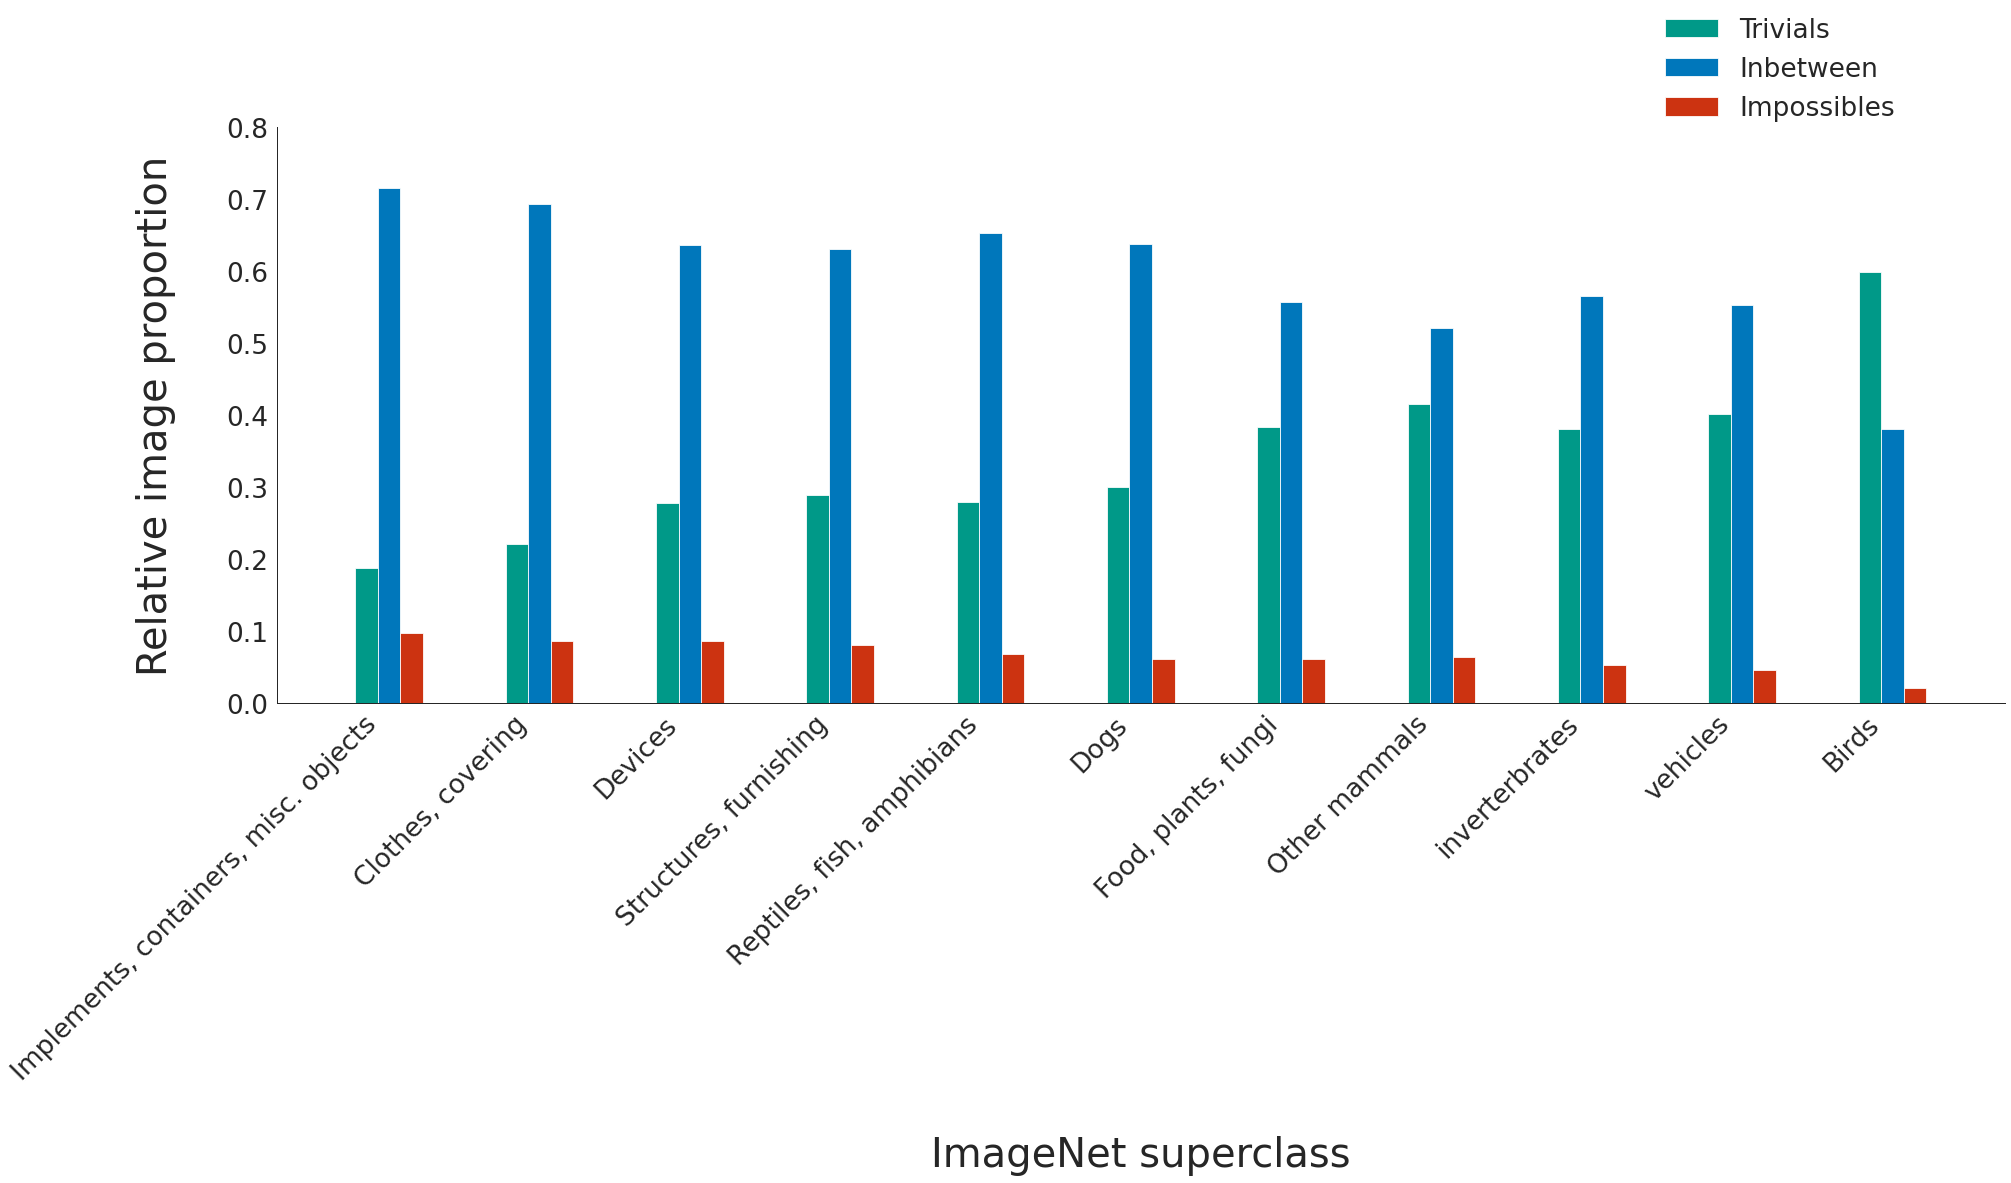

In [8]:
# Load data
mean_decisions_correct = np.load(folder_name + f"{base_network}_mean_decisions_correct.npy")

# Trivial items have a mean of 1, as all models got them right
trivial_inds = np.where(mean_decisions_correct == 1)[0]

# Impossible items have mean of 0, as no models got them right
impossible_inds = np.where(mean_decisions_correct == 0)[0]

# In-between items have mean between 0 and 1
inbetween_inds = np.where((mean_decisions_correct > 0) & (mean_decisions_correct < 1))[0]

# Pre-allocate lists for hypernyms
hyper_list_trivial = np.zeros(trivial_inds.shape, dtype=object)
hyper_list_impossible = np.zeros(impossible_inds.shape, dtype=object)
hyper_list_inbetween = np.zeros(inbetween_inds.shape, dtype=object)
hyper_list_all = np.zeros(mean_decisions_correct.shape, dtype=object)

# Load item and superclass idents
# Superclass list taken from: "From ImageNet to Image Classification: Contextualizing Progress on Benchmarks"
idents = np.load('imagenet_val_ident.npy', allow_pickle=True)
superclasses = np.load("superclasses.npy", allow_pickle=True)
superclass_list = list(superclasses.tolist().items())
superclass_names = np.zeros(11, dtype=object)

# Load identification file, which allows mapping class numbers to class names
names = np.loadtxt('imagenet_ident_class.txt', dtype="str", delimiter=":")

# Loop through trivial images and see where they are in superclass list
for ind, item in enumerate(trivial_inds):
    for sclass in range(len(superclass_list)):
        if idents[item, 0] in superclass_list[sclass][1]:
            hyper_list_trivial[ind] = superclass_list[sclass][0]             
            break

# Loop through impossible images and see where they are in superclass list
for ind, item in enumerate(impossible_inds):
    for sclass in range(len(superclass_list)):
        if idents[item, 0] in superclass_list[sclass][1]:
            hyper_list_impossible[ind] = superclass_list[sclass][0]               
            break

# Loop through inbetween and see where they are in superclass list
for ind, item in enumerate(inbetween_inds):
    for sclass in range(len(superclass_list)):
        if idents[item, 0] in superclass_list[sclass][1]:
            hyper_list_inbetween[ind] = superclass_list[sclass][0]
            break
            
# Loop through all images and see where they are in superclass list
for item in np.arange(0,len(mean_decisions_correct)):
    for sclass in range(len(superclass_list)):
        if idents[item, 0] in superclass_list[sclass][1]:
            hyper_list_all[item] = superclass_list[sclass][0]
            break
            
# Get all superclass names
for sclass in range(len(superclass_list)):
    superclass_names[sclass] = superclass_list[sclass][0]
    
# Get counts for how often each superclass appears in each category (trivial, impossible, inbetween, all)
counts_all = np.unique(hyper_list_all, return_counts=True)[1]
counts_inbetween = np.unique(hyper_list_inbetween, return_counts=True)[1]
counts_impossible = np.unique(hyper_list_impossible, return_counts=True)[1]
counts_trivial = np.unique(hyper_list_trivial, return_counts=True)[1]

# Transform counts so that they are relative to the other image types for the same superclass
counts_trivial_relative = np.zeros_like(counts_trivial, dtype=float)
counts_inbetween_relative = np.zeros_like(counts_inbetween, dtype=float)
counts_impossible_relative = np.zeros_like(counts_impossible, dtype=float)

# Loop through superclasses
for sclass in range(counts_all.shape[0]):
    
    # Total count of images for this superclass
    sclass_count = counts_trivial[sclass] + counts_inbetween[sclass] + counts_impossible[sclass]
    
    # Make relative counts
    counts_trivial_relative[sclass] = counts_trivial[sclass] / counts_all[sclass]
    counts_inbetween_relative[sclass] = counts_inbetween[sclass] / counts_all[sclass]
    counts_impossible_relative[sclass] = counts_impossible[sclass] / counts_all[sclass]

# Order by biggest ratio of impossible to trivials
order = np.flip(np.argsort(counts_impossible_relative / counts_trivial_relative))

# Plot superclass distributions in percent (divided by number of items in the respective category)
X = np.arange(len(superclass_list))
fig = plt.figure(figsize=(24,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.15, counts_trivial_relative[order], color = '#009988', width = 0.15, label="Trivials")
ax.bar(X + 0.30, counts_inbetween_relative[order], color = '#0077bb', width = 0.15, label="Inbetween")
ax.bar(X + 0.45, counts_impossible_relative[order], color = '#cc3311', width = 0.15, label="Impossibles")
plt.xticks(X + 0.25, np.array(sorted(superclass_names))[order], rotation=45, ha="right")
plt.ylim(0, 0.8)
plt.ylabel("Relative image proportion", size=40, labelpad=50)
plt.xlabel("ImageNet superclass", size=40, labelpad=50)
plt.legend(loc="center right", frameon=False, bbox_to_anchor=(0.95, 1.1))
sns.despine(top=True, right=True)
plt.savefig(figure_path + 'figure_11.png', dpi=150, bbox_inches='tight')

## Figure 12

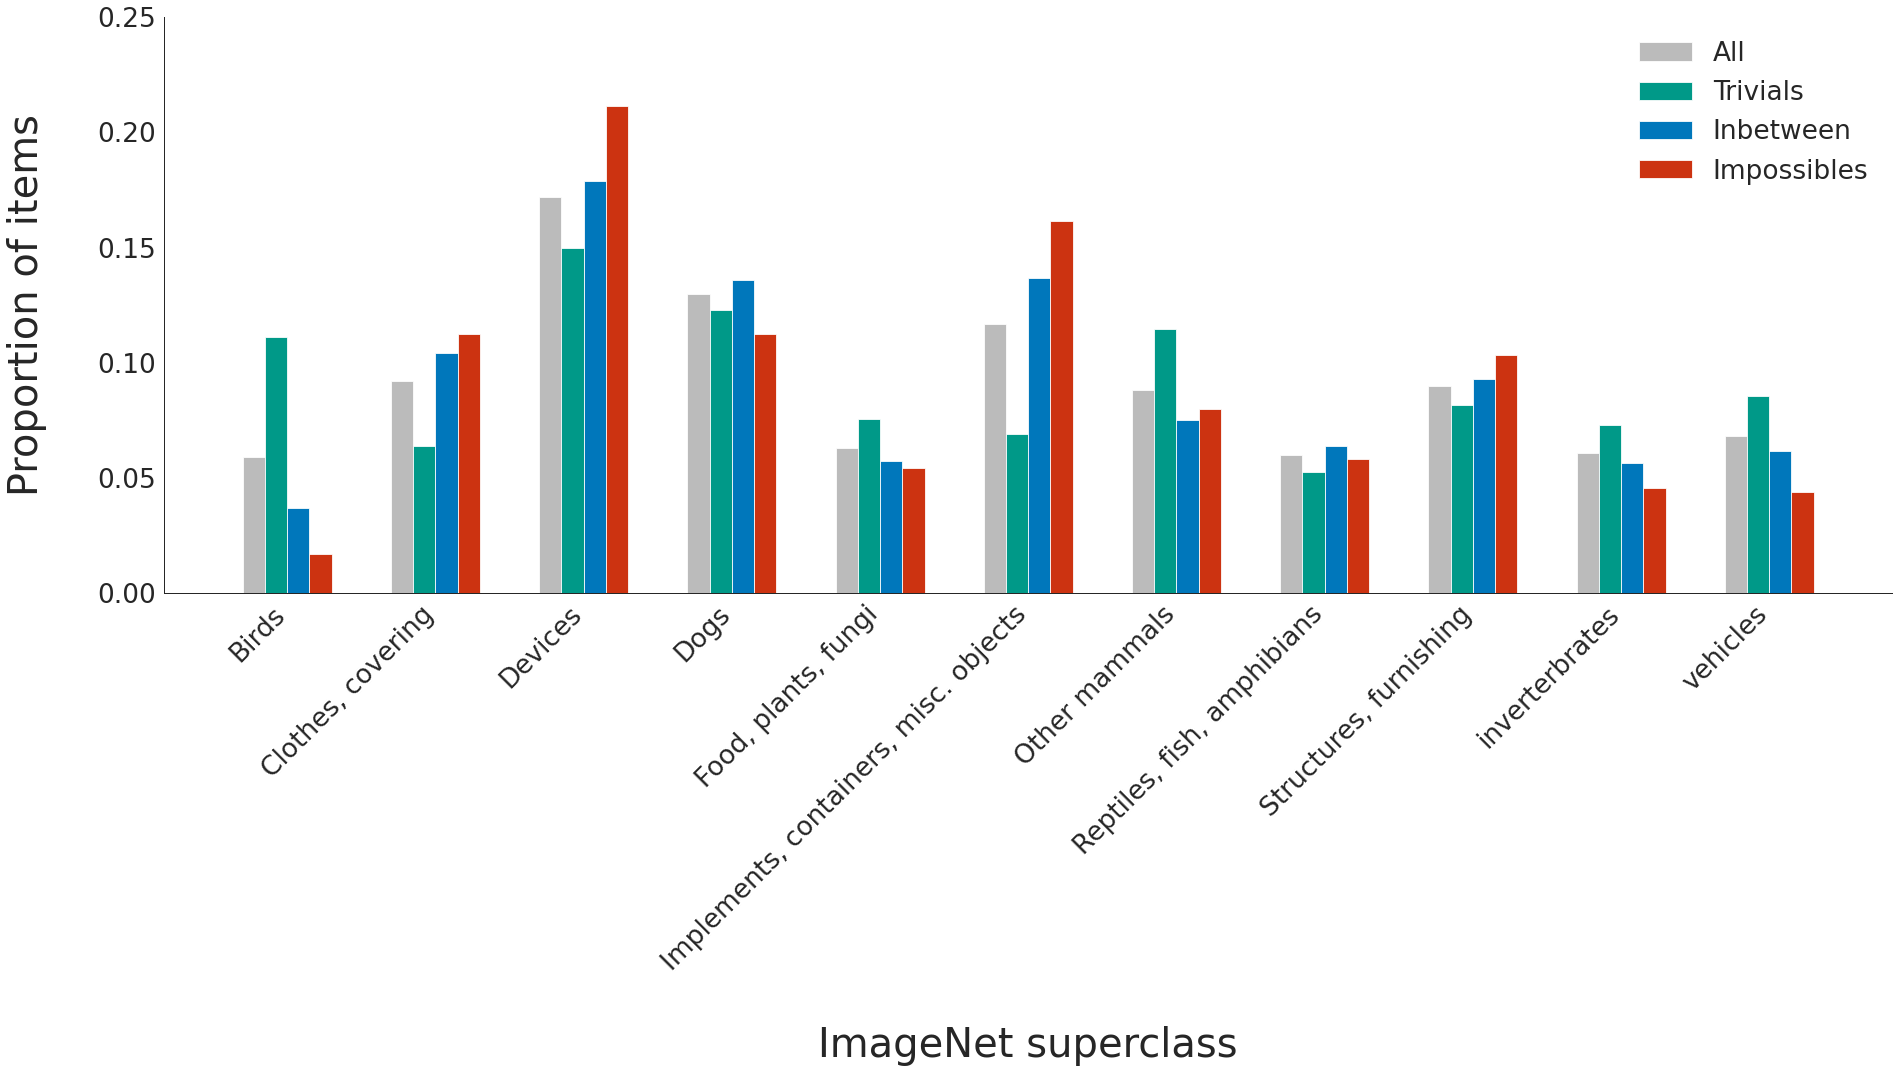

In [9]:
# Plot superclass distributions in percent (divided by number of items in the respective category)
X = np.arange(len(superclass_list))
fig = plt.figure(figsize=(24,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, counts_all / np.sum(counts_all), color = '#bbbbbb', width = 0.15, label="All")
ax.bar(X + 0.15, counts_trivial / np.sum(counts_trivial), color = '#009988', width = 0.15, label="Trivials")
ax.bar(X + 0.30, counts_inbetween / np.sum(counts_inbetween), color = '#0077bb', width = 0.15, label="Inbetween")
ax.bar(X + 0.45, counts_impossible / np.sum(counts_impossible), color = '#cc3311', width = 0.15, label="Impossibles")
plt.xticks(X + 0.25, sorted(superclass_names), rotation=45, ha="right")
plt.ylim(0, 0.25)
plt.ylabel("Proportion of items", size=40, labelpad=50)
plt.xlabel("ImageNet superclass", size=40, labelpad=50)
plt.legend(loc="upper right", frameon=False)
sns.despine(top=True, right=True)
plt.savefig(figure_path + 'figure_12.png', dpi=150, bbox_inches='tight')

## Figure 13

Using Res18 order


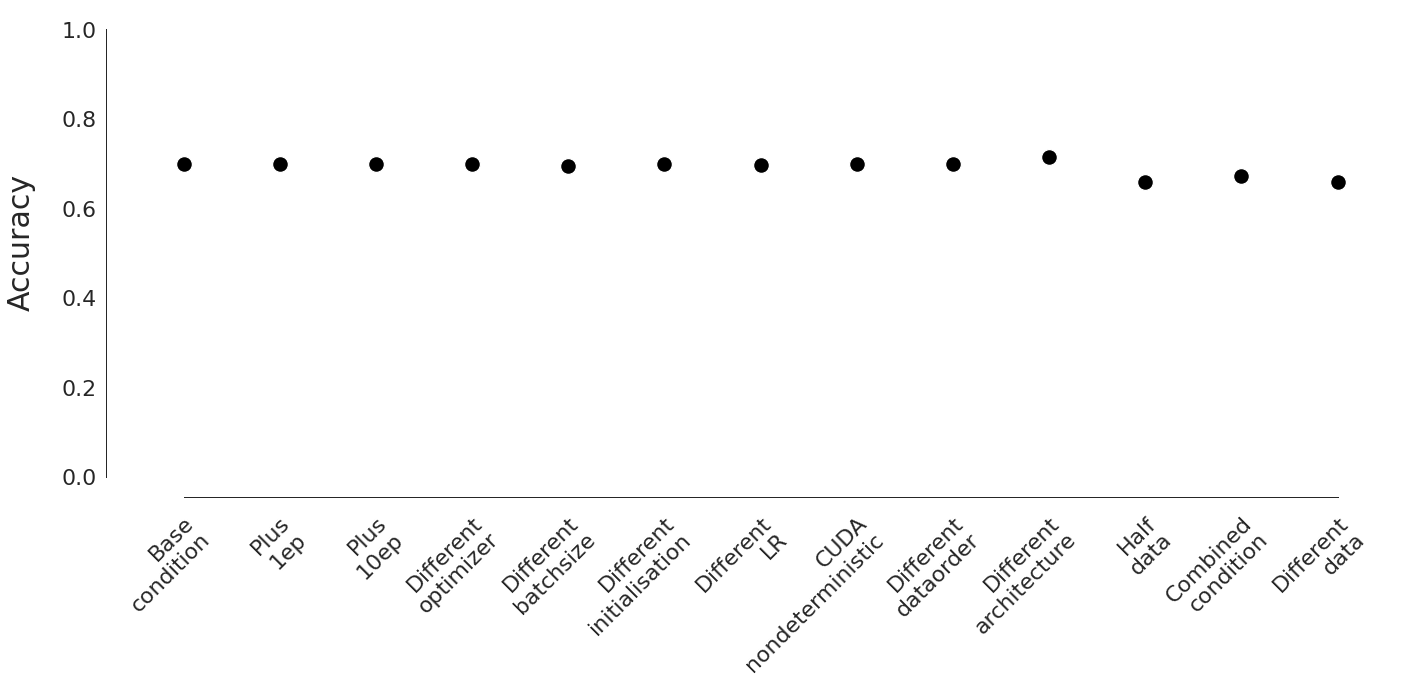

In [10]:
from scripts.analysis_helpers import prep_condition

# Load ordering and data arrays
base_network = "Res18"
folder_name = f"results/{base_network}/"
main_array = np.load(folder_name + f"{base_network}_main_array.npy", allow_pickle=True)
res18_order = np.load(folder_name + f"{base_network}_main_order.npy", allow_pickle=True)
conditions = [f"{base_network}_Base_condition",
              f"{base_network}_Plus_1ep",
              f"{base_network}_Plus_10ep",
              f"{base_network}_Different_optimizer",
              f"{base_network}_Different_batchsize",
              f"{base_network}_Different_initialisation",
              f"{base_network}_Different_LR",
              f"{base_network}_CUDA_nondeterministic",
              f"{base_network}_Different_dataorder",
              f"{base_network}_Different_architecture",
              f"{base_network}_Different_data",
              f"{base_network}_Half_data",
              f"{base_network}_Combined_condition"]

# Remove first \n from labels
labels = main_array[0, res18_order, 0]
labels_correct = np.empty(len(labels), dtype=object)
for ind, label in enumerate(labels):
    labels_correct[ind] = label[1:]

# Loop through conditions to make array containing accuracy in last epoch
accs_lastep = np.zeros(len(conditions))
for ind, condition in enumerate(conditions):

    # Load data, conditions with more epochs than base are stored in base file
    results, val_acc, num_epochs, num_models, num_base_epochs = prep_condition(condition, folder_name, base_network)
    
    if val_acc.shape[0] == 1:
        accs_lastep[ind] = val_acc[0, num_base_epochs-1]
    else:
        accs_lastep[ind] = np.mean(val_acc[:, num_base_epochs-1])
        
from scripts.analysis_helpers import main_plot_acc
main_plot_acc(accs_lastep, 0, figure_path, base_network, labels_correct, "Accuracy", res18_order)
plt.savefig(figure_path + 'figure_13.png', dpi=150, bbox_inches='tight')

## Figure 14

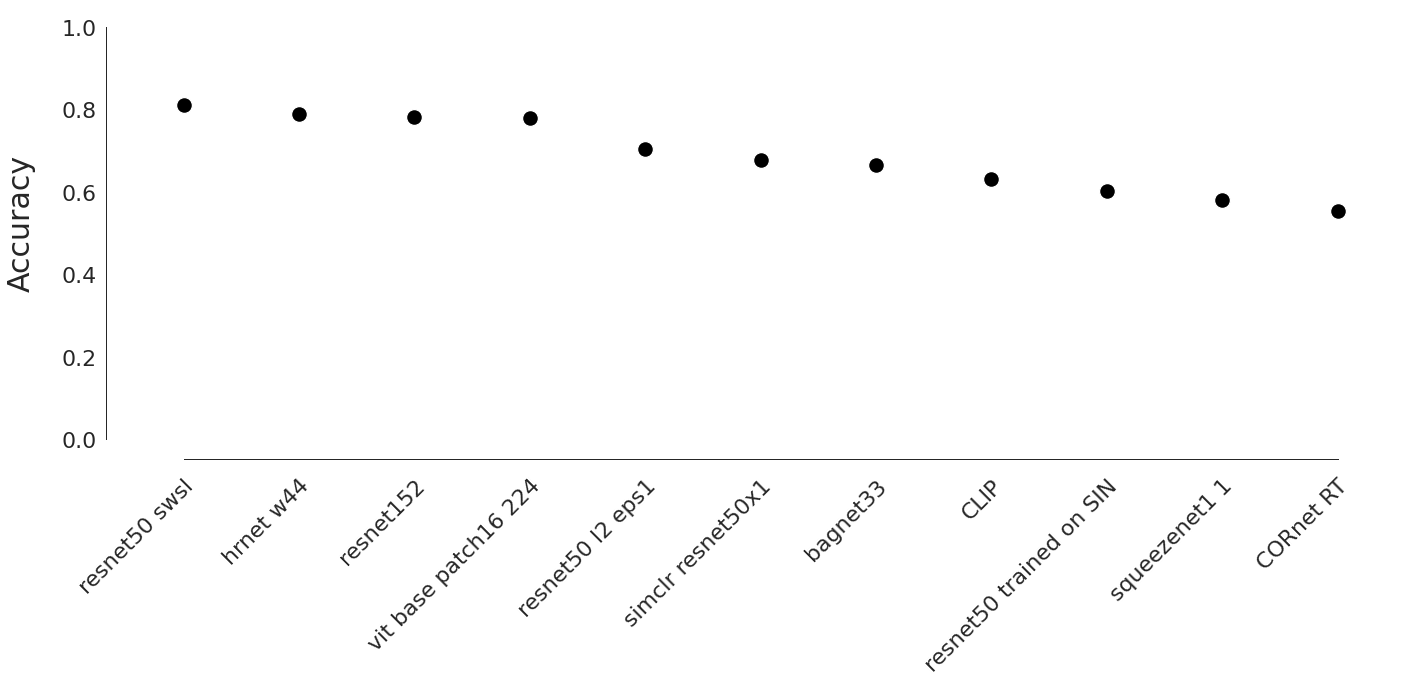

In [11]:
# Load accuracy array
base_network = "Rebuttal"
folder_name = f"results/{base_network}/"
conditions = os.listdir(folder_name)
conditions = [x for x in conditions if not x.endswith(".npy")]
model_accuracies = np.load(folder_name + f"{base_network}_model_accuracies.npy", allow_pickle=True)

# Remove underlines from model name strings for prettier x axis labels in accuracy plot
labels_correct = np.zeros((len(conditions)), dtype="object")
for ind, string in enumerate(conditions):
    labels_correct[ind] = string.replace("_", " ")
    
# Plot accuracy for SOTA models
main_plot_acc(model_accuracies, 0, figure_path, base_network, labels_correct, "Accuracy")
plt.savefig(figure_path + 'figure_14.png', dpi=150, bbox_inches='tight')

## Figure 15

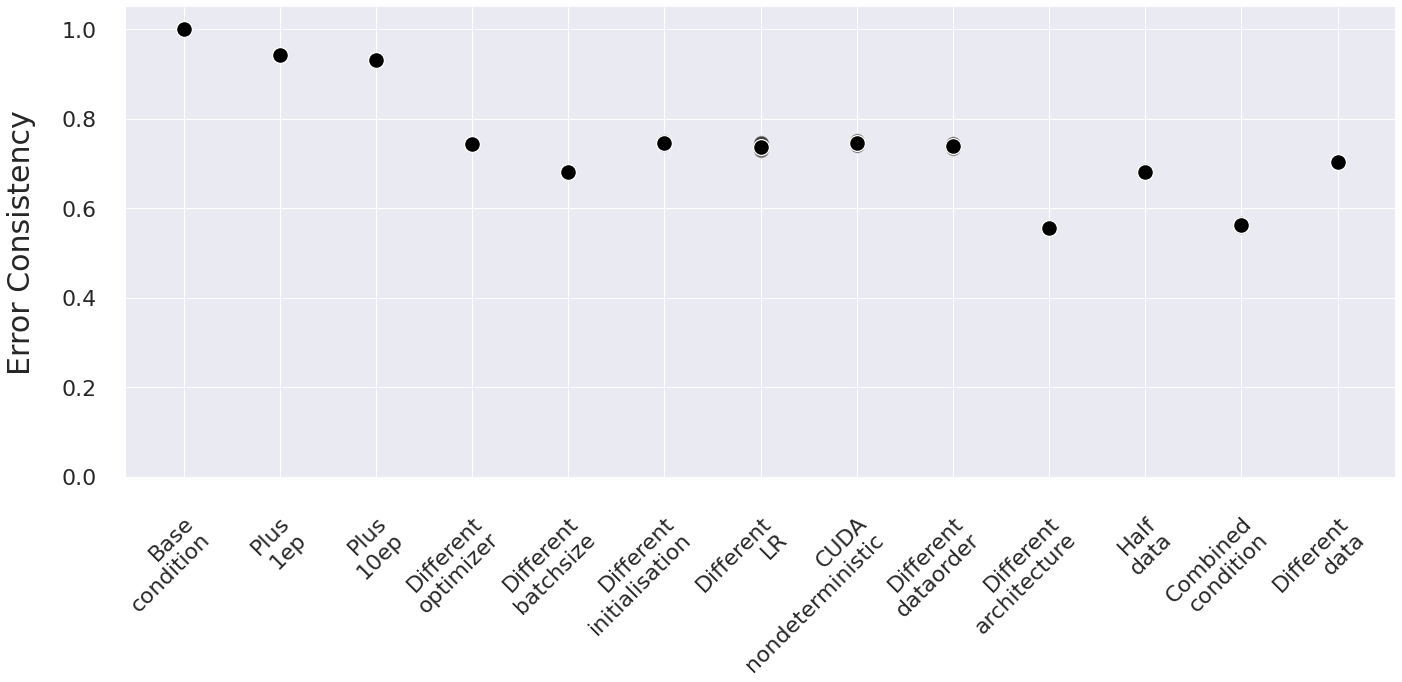

In [12]:
# Make main plot
base_network = "VGG11"
epoch = 30
folder_name = f"results/{base_network}/"
order_high_low = np.load("results/Res18/Res18_main_order.npy", allow_pickle=True)
main = np.load(folder_name + f"{base_network}_main_array.npy", allow_pickle=True)

# Order main array according to last epoch
num_epochs = main.shape[0]
num_conditions = main.shape[1]
econ_means = np.zeros(num_conditions)

# Order conditions by highest mean
fig = plt.figure(figsize=(20, 10))

# Fill array for mean values
econ_means = np.nanmean(main[epoch, : , 1:], axis=1)

# Order arrays from high to low
ordered_means = econ_means[order_high_low]
ordered_econs = main[epoch, order_high_low, 1:]

# Remove first \n from labels
labels = main[epoch, order_high_low, 0]
labels_correct = np.empty(len(labels), dtype=object)
for ind, label in enumerate(labels):
    labels_correct[ind] = label[1:]

#plt.xticks(np.arange(0, len(main[0, :, 0]), 1), labels = np.arange(1,12,1), rotation=60)
for ind in range(num_conditions):
    ax = sns.scatterplot(y=ordered_econs[ind], x=ind, s=250, marker='o', color='black', alpha=0.5)

# Plot means and individual models
ax = sns.scatterplot(data=ordered_means, s=250, marker='o', color='black', alpha=1.0)

# Plot settings
sns.set(font_scale = 2)
ax.set_ylabel("Error Consistency", fontsize=30, labelpad=25)
ax.set_ylim(0, 1.05)
ax.set_xticks(np.arange(0, len(main[0, :, 0]), 1))
ax.set_xticklabels(labels_correct, ha='right')

# Context setting and saving plot
sns.despine(top=True, right=True, offset=20, trim=True)
ax.tick_params(axis = 'x', pad=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.savefig(figure_path + 'figure_15.png', dpi=150, bbox_inches='tight')

## Figure 16

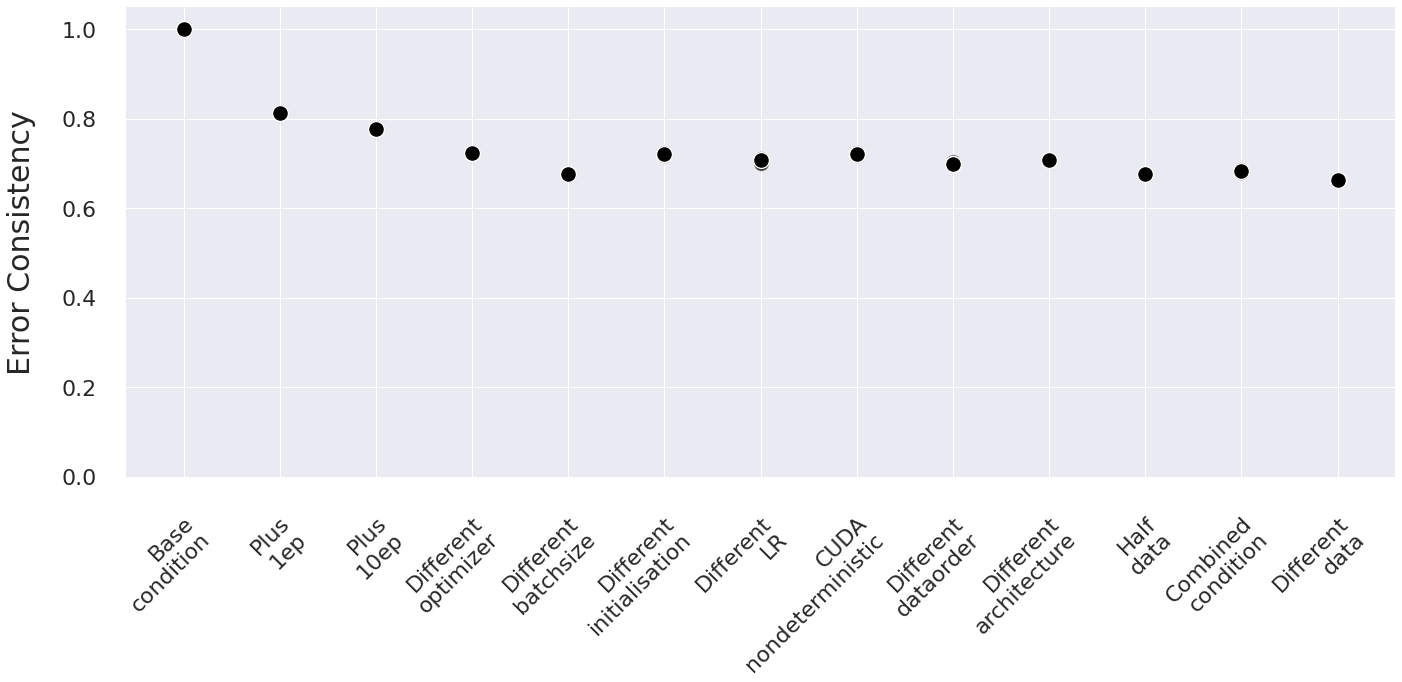

In [13]:
# Make main plot
base_network = "Dense121"
epoch = 30
folder_name = f"results/{base_network}/"
order_high_low = np.load("results/Res18/Res18_main_order.npy", allow_pickle=True)
main = np.load(folder_name + f"{base_network}_main_array.npy", allow_pickle=True)

# Order main array according to last epoch
num_epochs = main.shape[0]
num_conditions = main.shape[1]
econ_means = np.zeros(num_conditions)

# Order conditions by highest mean
fig = plt.figure(figsize=(20, 10))

# Fill array for mean values
econ_means = np.nanmean(main[epoch, : , 1:], axis=1)

# Order arrays from high to low
ordered_means = econ_means[order_high_low]
ordered_econs = main[epoch, order_high_low, 1:]

# Remove first \n from labels
labels = main[epoch, order_high_low, 0]
labels_correct = np.empty(len(labels), dtype=object)
for ind, label in enumerate(labels):
    labels_correct[ind] = label[1:]

#plt.xticks(np.arange(0, len(main[0, :, 0]), 1), labels = np.arange(1,12,1), rotation=60)
for ind in range(num_conditions):
    ax = sns.scatterplot(y=ordered_econs[ind], x=ind, s=250, marker='o', color='black', alpha=0.5)

# Plot means and individual models
ax = sns.scatterplot(data=ordered_means, s=250, marker='o', color='black', alpha=1.0)

# Plot settings
sns.set(font_scale = 2)
ax.set_ylabel("Error Consistency", fontsize=30, labelpad=25)
ax.set_ylim(0, 1.05)
ax.set_xticks(np.arange(0, len(main[0, :, 0]), 1))
ax.set_xticklabels(labels_correct, ha='right')

# Context setting and saving plot
sns.despine(top=True, right=True, offset=20, trim=True)
ax.tick_params(axis = 'x', pad=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.savefig(figure_path + 'figure_16.png', dpi=150, bbox_inches='tight')

## Figure 17

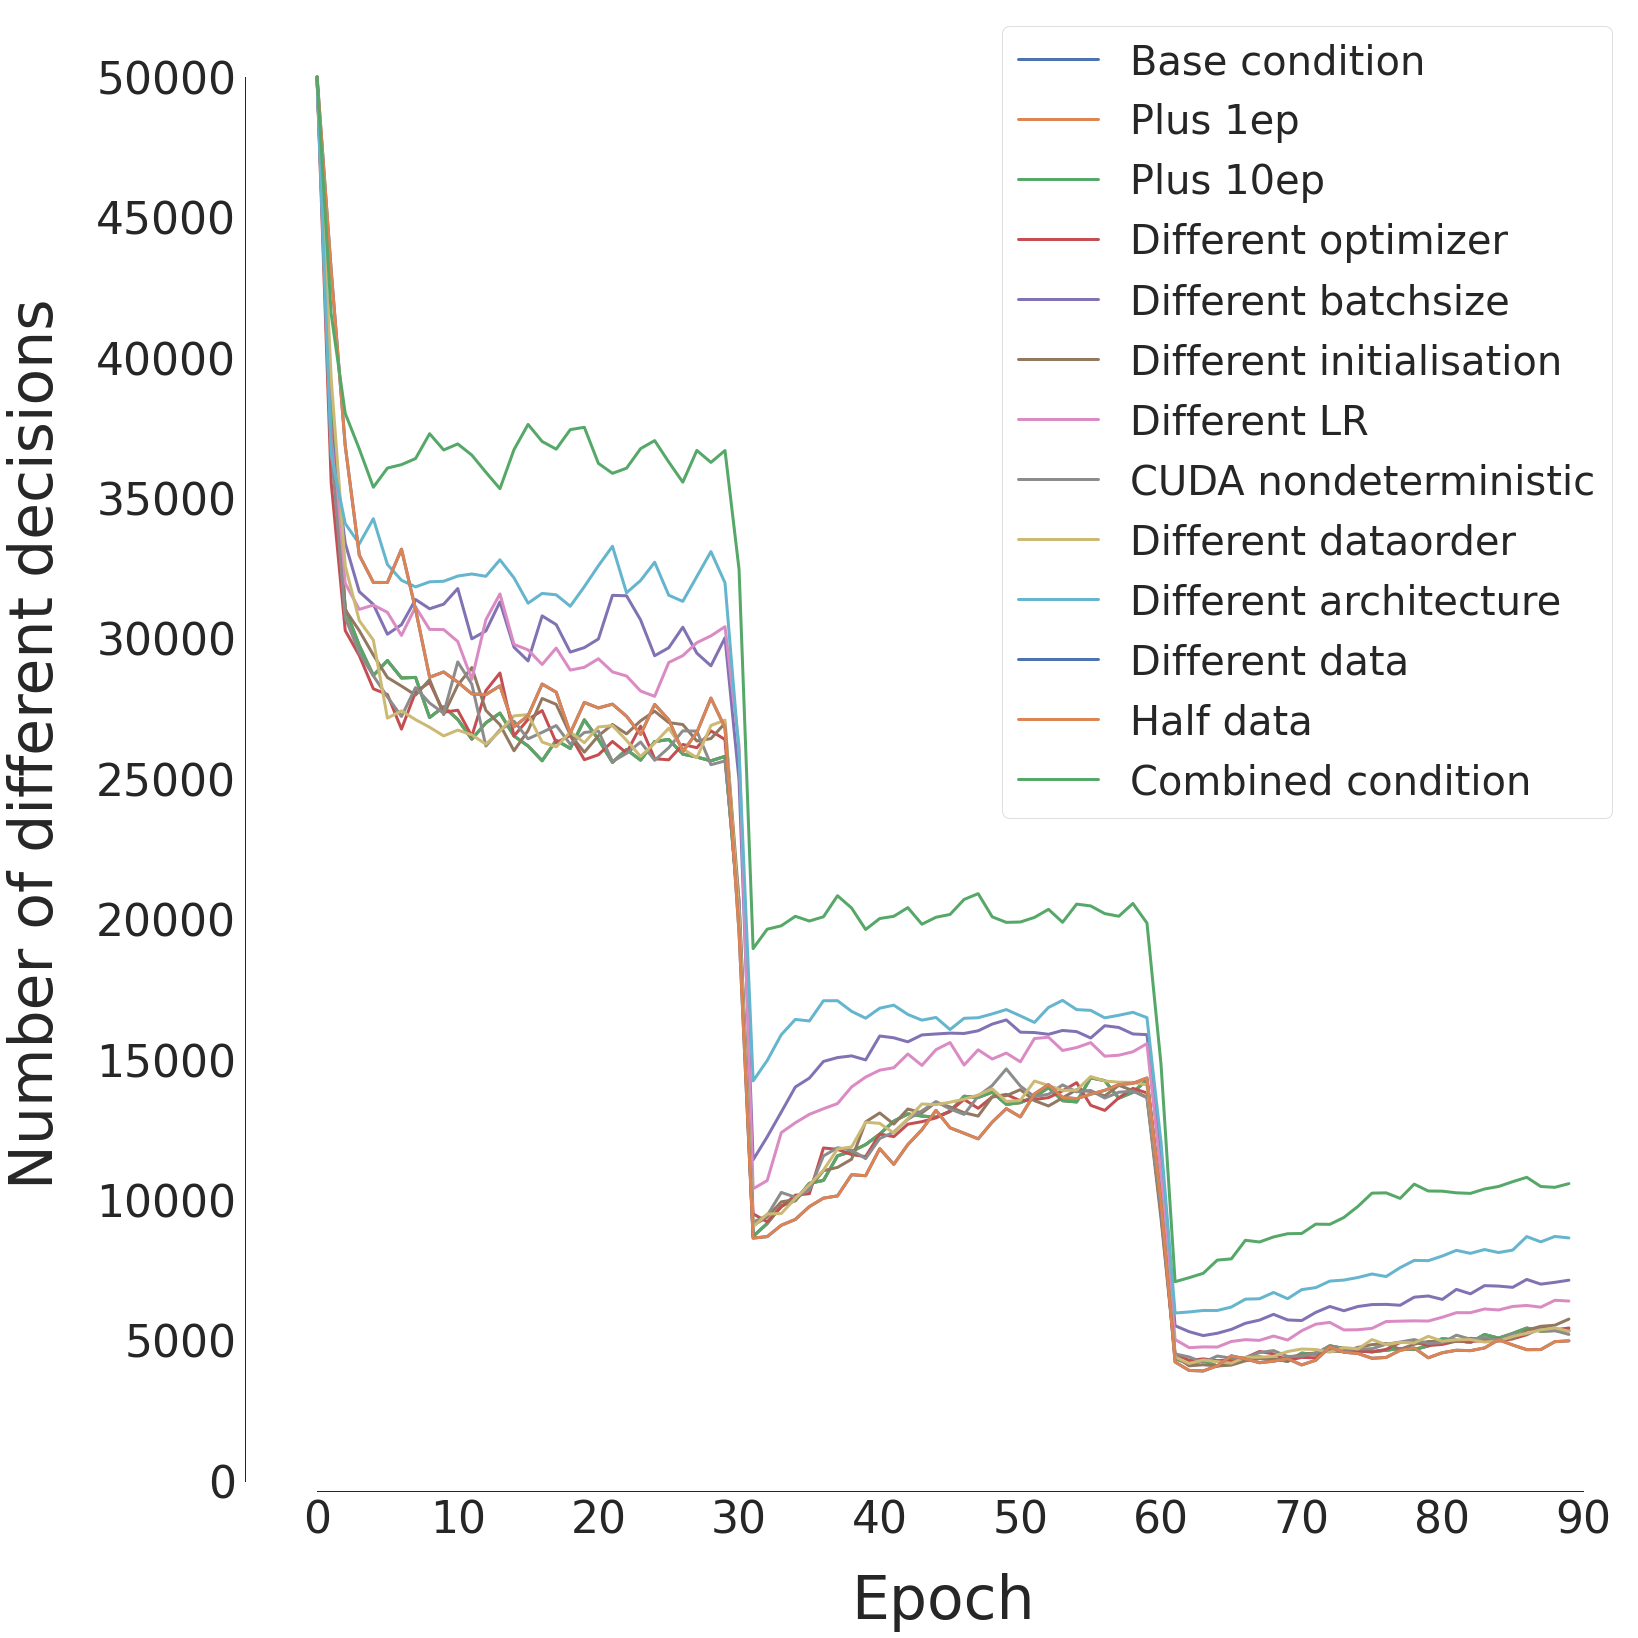

In [14]:
from scripts.analysis_helpers import plot_decisions_change
base_network = "Res18"
folder_name = f"results/{base_network}/"
decisions_correct = np.load(folder_name + f"{base_network}_decisions_correct.npy", allow_pickle=True)
decisions_change = np.load(folder_name + f"{base_network}_decisions_change.npy", allow_pickle=True)
conditions = [f"{base_network}_Base_condition",
              f"{base_network}_Plus_1ep",
              f"{base_network}_Plus_10ep",
              f"{base_network}_Different_optimizer",
              f"{base_network}_Different_batchsize",
              f"{base_network}_Different_initialisation",
              f"{base_network}_Different_LR",
              f"{base_network}_CUDA_nondeterministic",
              f"{base_network}_Different_dataorder",
              f"{base_network}_Different_architecture",
              f"{base_network}_Different_data",
              f"{base_network}_Half_data",
              f"{base_network}_Combined_condition"]

# Reformat decisions change array to be between 0 and 1 
decisions_change_c = (decisions_correct.shape[1] - decisions_change) / decisions_correct.shape[1]

# Plot changes in decisions for each condition
plot_decisions_change(decisions_change_c, figure_path, base_network, conditions, decisions_correct.shape[1])
plt.savefig(figure_path + 'figure_17.png', dpi=150, bbox_inches='tight')

## Figures 18 and 19
#### In order to run these cells, the locations of the data sets "data_dir" have to be re-defined
#### Please note that this is just an example and does not export the exact images shown

In [15]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        
        return tuple_with_path
    
def init_dataset(DSET, NUM, DATA, MODEL, CONDITION, train=True):
    """
    :param DSET: Which dataset to use
    :param NUM: Model index
    :param DATA: Whether to use same or different datasets
    :param train: Whether to choose train or test dataset
    :return: Initialized dataset
    """

    # Check which dataset is supposed to be used
    if DSET == "ImageNet":

        # Dataset location
        data_dir = '/scratch_local/datasets/ImageNet2012/'

        # Check whether train or validation dataset is needed
        if train is True:
            path = os.path.join(data_dir, 'train')

            # Initialize dataset and apply transforms
            dataset = ImageFolderWithPaths(
                path,
                transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    #normalize,
                ]))

        elif train is False:
            path = os.path.join(data_dir, 'val')

            # Initialize dataset and apply transforms
            dataset = ImageFolderWithPaths(
                path,
                transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    #normalize,
                ]))
            
    
    if DSET == "CIFAR100":

        # Dataset location
        data_dir = '/mnt/qb/work/wichmann/lschulzebuschoff43/cifar100/'

        # Set normalization parameters
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     
        # Check whether train or validation dataset is needed
        if train is True:
            path = os.path.join(data_dir, 'train')

            # Initialize dataset and apply transforms
            dataset = datasets.ImageFolder(
                path,
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, 4),
                    transforms.ToTensor(),
                    normalize,
                ]))

        elif train is False:
            path = os.path.join(data_dir, 'val')

            # Initialize dataset and apply transforms
            dataset = datasets.ImageFolder(
                path,
                transforms.Compose([
                    transforms.ToTensor(),
                    #normalize,
                ]))

    return dataset

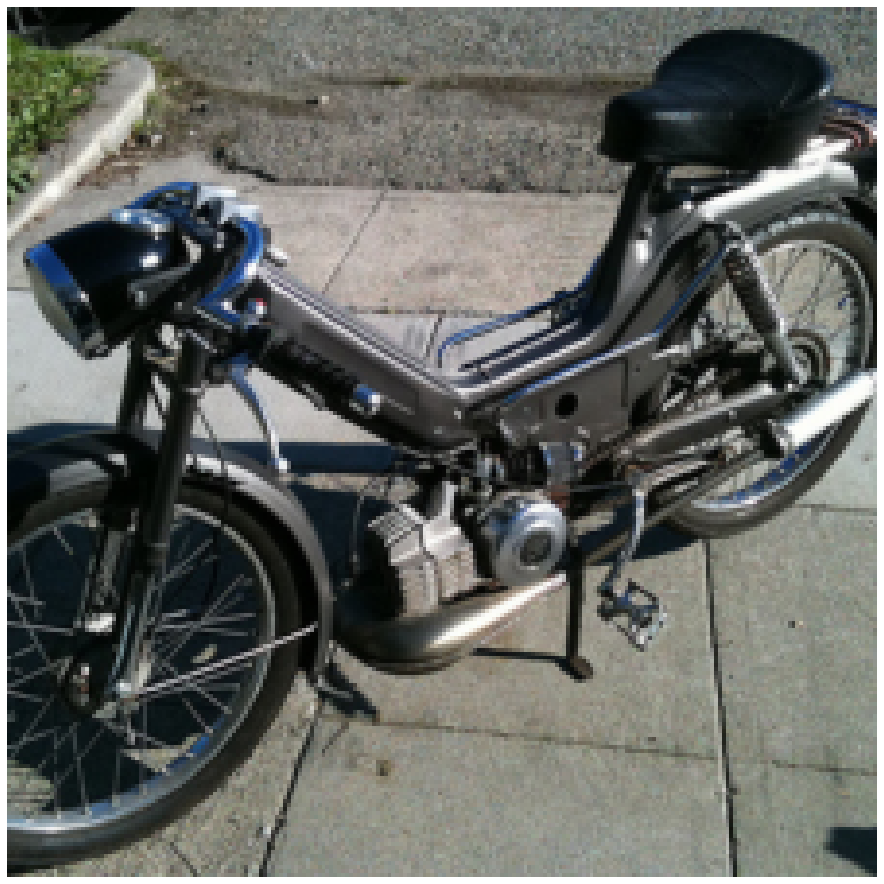

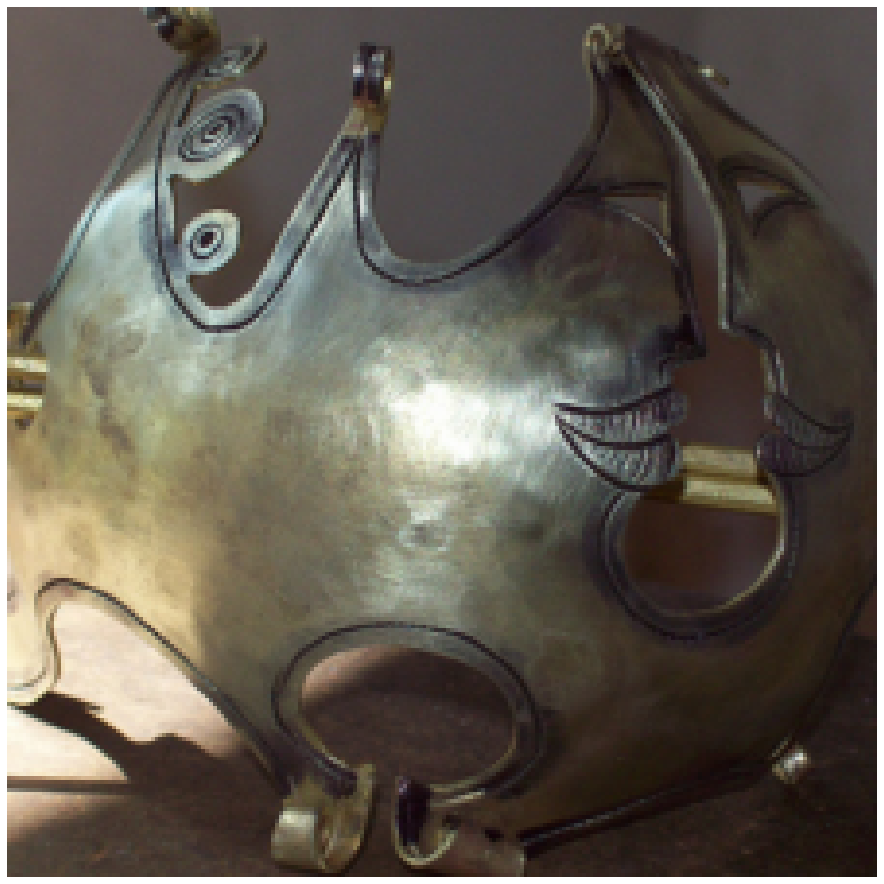

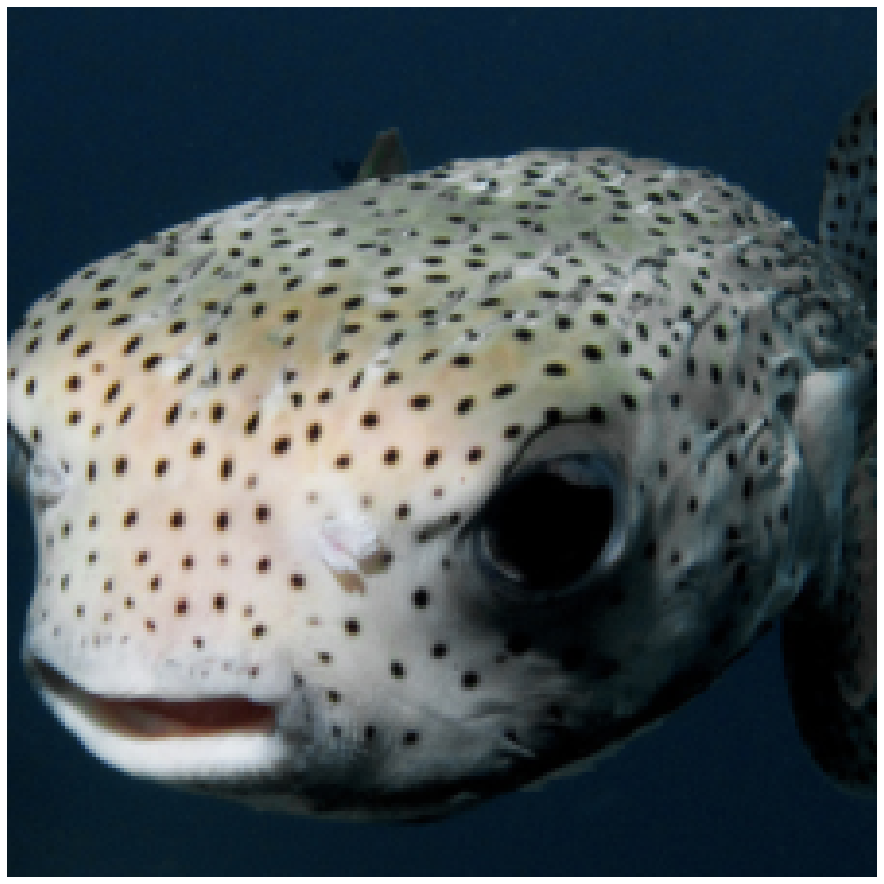

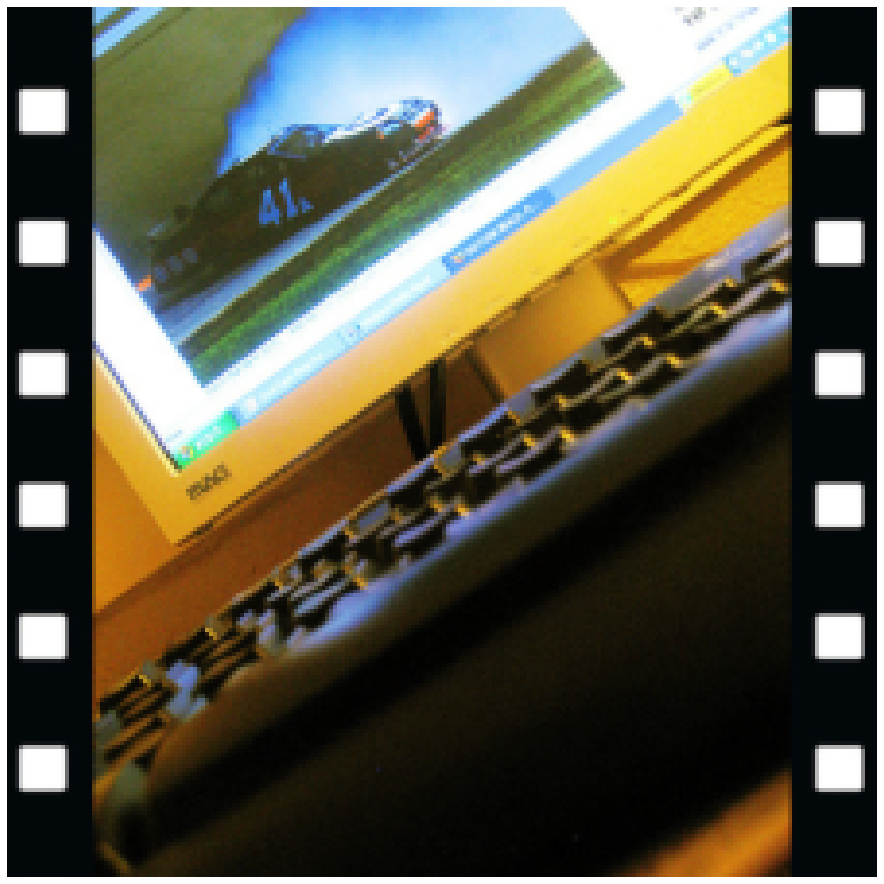

In [16]:
# Show wrong images for ResNet-18 on ImageNet
base_network = "Res18"
val_set = init_dataset("ImageNet", _, _, _, _, train=False)
mean_decisions_correct = np.load(folder_name + f"{base_network}_mean_decisions_correct.npy", allow_pickle=True)
clean_order = np.flip((mean_decisions_correct[:,-1]).argsort())

# Imports and parameters for example image plots
from scripts.analysis_helpers import plotSingle
exp_loc = []
num_samples = 2
np.random.seed(1312)

# Get indices of random bad and good images
bad_inds = np.random.choice(np.flip(clean_order)[0:1000], size=num_samples, replace=False)
good_inds = np.random.choice(clean_order[0:1000], size=num_samples, replace=False)

# Get 10 most falsely decided on images
for index in range(num_samples):

    # Get respective image from validation set
    image_good = np.transpose(val_set[good_inds[index]][0].cpu().detach().numpy(), (1, 2, 0))
    image_bad = np.transpose(val_set[bad_inds[index]][0].cpu().detach().numpy(), (1, 2, 0))

    plt.figure(figsize=(16,16))
    plt.imshow(image_good)
    plt.axis('off')
    plt.savefig(figure_path + 'figure_18_a.jpg', bbox_inches='tight')

    plt.figure(figsize=(16,16))
    plt.imshow(image_bad)
    plt.axis('off')
    plt.savefig(figure_path + 'figure_18_b.jpg', bbox_inches='tight') 

## Figure 20

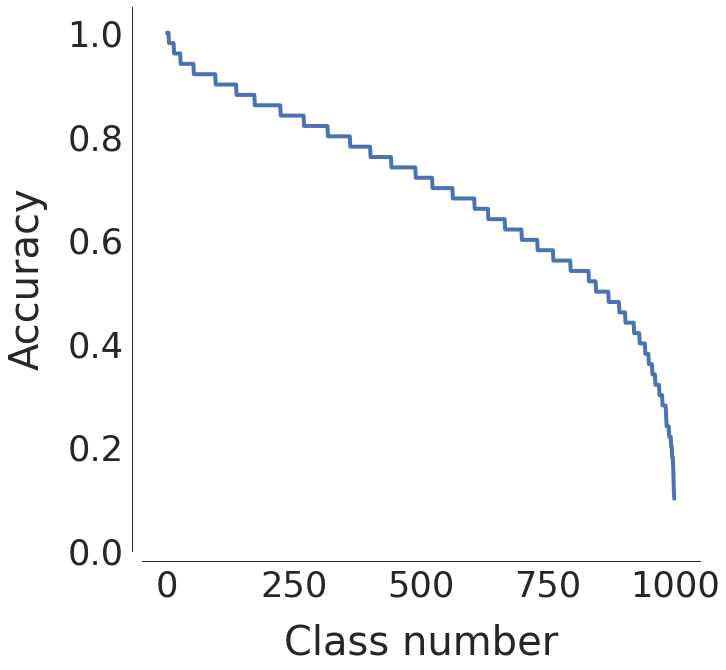

In [17]:
# Set base network and conditions
from scripts.analysis_helpers import prep_condition
base_network = "Res18"
folder_name = f"./results/{base_network}/"

conditions = [f"{base_network}_Base_condition",
              f"{base_network}_Plus_1ep",
              f"{base_network}_Plus_10ep",
              f"{base_network}_Different_optimizer",
              f"{base_network}_Different_batchsize",
              f"{base_network}_Different_initialisation",
              f"{base_network}_Different_LR",
              f"{base_network}_CUDA_nondeterministic",
              f"{base_network}_Different_dataorder",
              f"{base_network}_Different_architecture",
              f"{base_network}_Different_data",
              f"{base_network}_Half_data",
              f"{base_network}_Combined_condition"]

# Get base array and allocate list for main plot
base, _, _, _, num_base_epochs = prep_condition(f"{base_network}_Base_condition", folder_name, base_network)

# Get number of classes
num_classes = len(np.unique(base[0][0][2]))

# Get mean accuracies for each class
class_accuracies = np.zeros(num_classes)
equal_answers = np.equal(base[0][num_base_epochs-1][1], base[0][num_base_epochs-1][2]).numpy()
for ind in range(num_classes):
    class_accuracies[ind] = np.mean(equal_answers[np.where(base[0][num_base_epochs-1][2] == ind)[0]])
    
plt.figure(figsize=(10,10))
plt.plot(np.flip(np.sort(class_accuracies)), linewidth=4);


# Plot settings
sns.set_context("paper", font_scale=4.0)
sns.set_style("white")
sns.color_palette("viridis", as_cmap=True)
sns.despine(right=True, top=True, offset=10, trim=False)
plt.xlabel("Class number", fontsize=40, labelpad=20)
plt.ylabel("Accuracy", fontsize=40, labelpad=20)
plt.ylim(0,1.05)

plt.savefig(figure_path + 'figure_20_a.png', dpi=150, bbox_inches='tight')

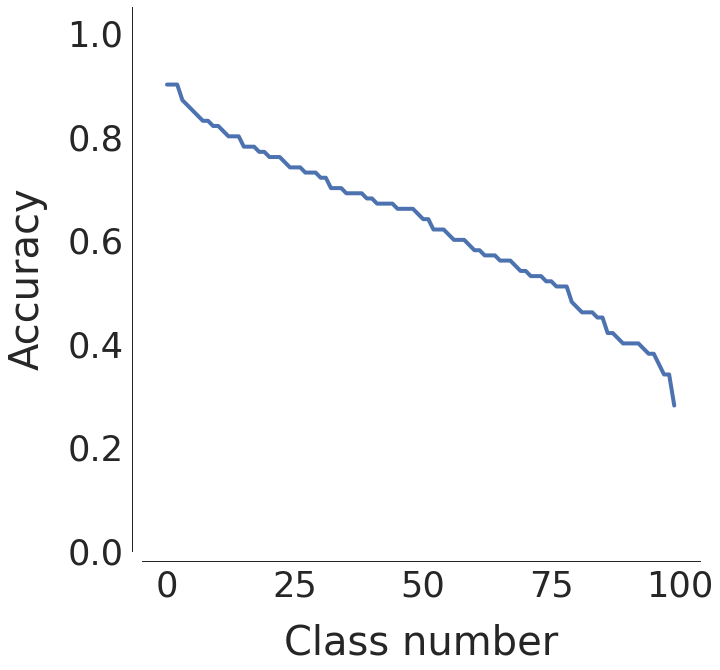

In [18]:
# Set base network and conditions
from scripts.analysis_helpers import prep_condition
base_network = "Res18CIFAR"
folder_name = f"./results/{base_network}/"

conditions = [f"{base_network}_Base_condition",
              f"{base_network}_Plus_1ep",
              f"{base_network}_Plus_10ep",
              f"{base_network}_Different_optimizer",
              f"{base_network}_Different_batchsize",
              f"{base_network}_Different_initialisation",
              f"{base_network}_Different_LR",
              f"{base_network}_CUDA_nondeterministic",
              f"{base_network}_Different_dataorder",
              f"{base_network}_Different_architecture",
              f"{base_network}_Different_data",
              f"{base_network}_Half_data",
              f"{base_network}_Combined_condition"]

# Get base array and allocate list for main plot
base, _, _, _, num_base_epochs = prep_condition(f"{base_network}_Base_condition", folder_name, base_network)

# Get number of classes
num_classes = len(np.unique(base[0][0][2]))

# Get mean accuracies for each class
class_accuracies = np.zeros(num_classes)
equal_answers = np.equal(base[0][num_base_epochs-1][1], base[0][num_base_epochs-1][2]).numpy()
for ind in range(num_classes):
    class_accuracies[ind] = np.mean(equal_answers[np.where(base[0][num_base_epochs-1][2] == ind)[0]])
    
plt.figure(figsize=(10,10))
plt.plot(np.flip(np.sort(class_accuracies)), linewidth=4);


# Plot settings
sns.set_context("paper", font_scale=4.0)
sns.set_style("white")
sns.color_palette("viridis", as_cmap=True)
sns.despine(right=True, top=True, offset=10, trim=False)
plt.xlabel("Class number", fontsize=40, labelpad=20)
plt.ylabel("Accuracy", fontsize=40, labelpad=20)
plt.ylim(0,1.05)

plt.savefig(figure_path + 'figure_20_b.png', dpi=150, bbox_inches='tight')

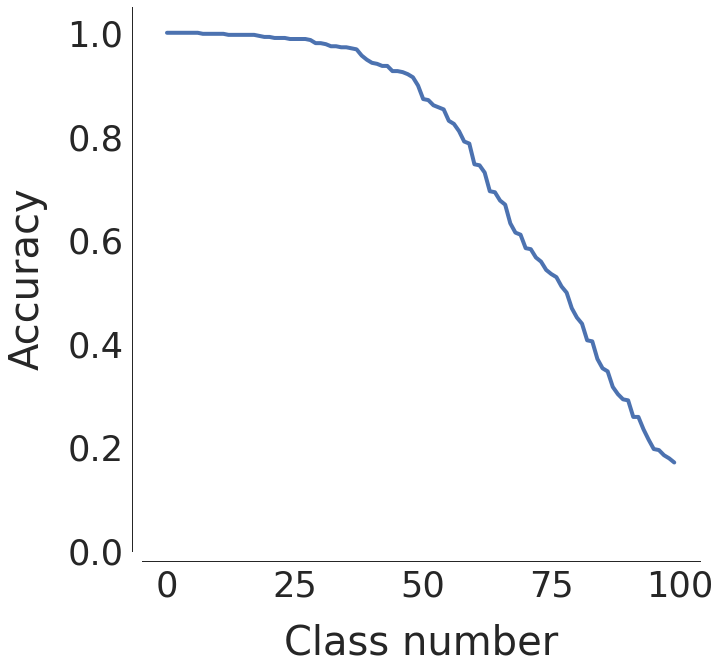

In [19]:
# Set base network and conditions
from scripts.analysis_helpers import prep_condition
base_network = "Res18fc100"
folder_name = f"./results/{base_network}/"

conditions = [f"{base_network}_Base_condition",
              f"{base_network}_Plus_1ep",
              f"{base_network}_Plus_10ep",
              f"{base_network}_Different_optimizer",
              f"{base_network}_Different_batchsize",
              f"{base_network}_Different_initialisation",
              f"{base_network}_Different_LR",
              f"{base_network}_CUDA_nondeterministic",
              f"{base_network}_Different_dataorder",
              f"{base_network}_Different_architecture",
              f"{base_network}_Different_data",
              f"{base_network}_Half_data",
              f"{base_network}_Combined_condition"]

# Get base array and allocate list for main plot
base, _, _, _, num_base_epochs = prep_condition(f"{base_network}_Base_condition", folder_name, base_network)

# Get number of classes
num_classes = len(np.unique(base[0][0][2]))

# Get mean accuracies for each class
class_accuracies = np.zeros(num_classes)
equal_answers = np.equal(base[0][num_base_epochs-1][1], base[0][num_base_epochs-1][2]).numpy()
for ind in range(num_classes):
    class_accuracies[ind] = np.mean(equal_answers[np.where(base[0][num_base_epochs-1][2] == ind)[0]])
    
plt.figure(figsize=(10,10))
plt.plot(np.flip(np.sort(class_accuracies)), linewidth=4);


# Plot settings
sns.set_context("paper", font_scale=4.0)
sns.set_style("white")
sns.color_palette("viridis", as_cmap=True)
sns.despine(right=True, top=True, offset=10, trim=False)
plt.xlabel("Class number", fontsize=40, labelpad=20)
plt.ylabel("Accuracy", fontsize=40, labelpad=20)
plt.ylim(0,1.05)

plt.savefig(figure_path + 'figure_20_c.png', dpi=150, bbox_inches='tight')

## Figure 21

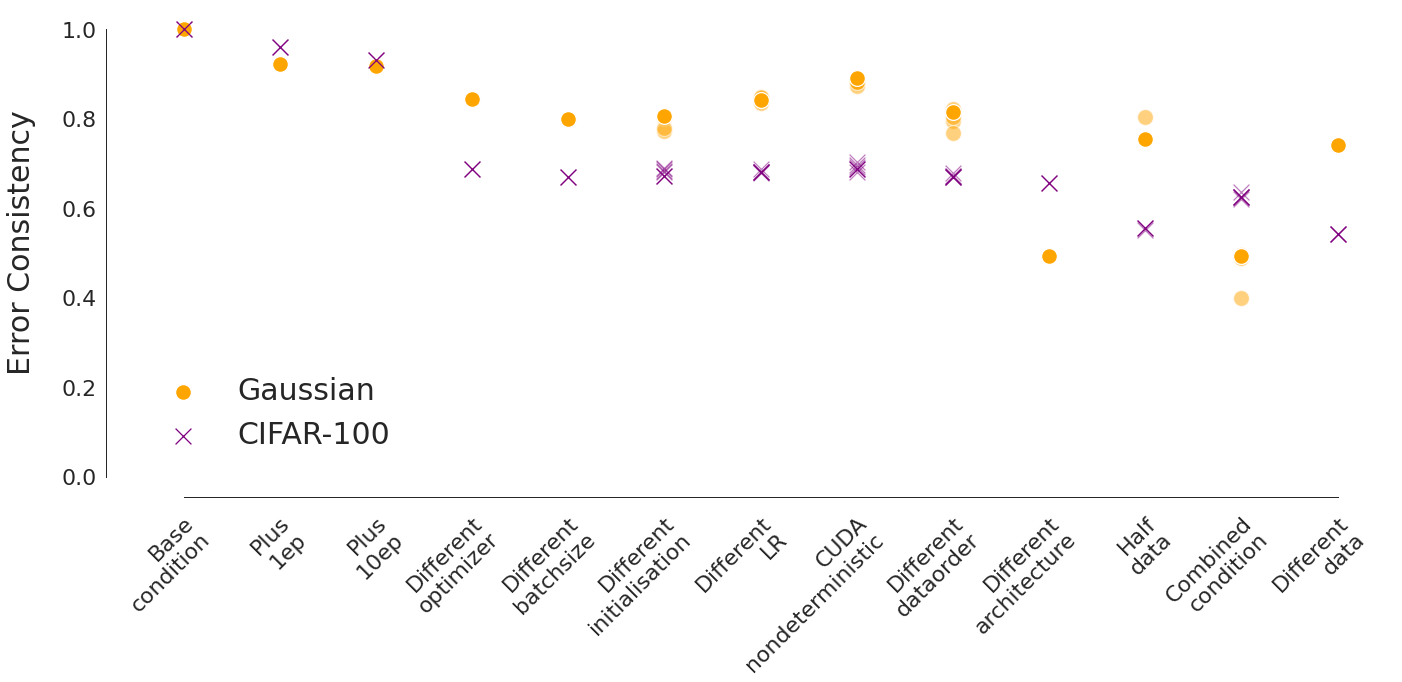

In [20]:
main = np.load("results/Res18fc100/Res18fc100_main_array.npy", allow_pickle=True)
main2 = np.load("results/Res18CIFAR/Res18CIFAR_main_array.npy", allow_pickle=True)
order_high_low = np.load("results/Res18/Res18_main_order.npy", allow_pickle=True)
epoch = 30

# Pre-allocate arrays
num_epochs = main.shape[0]
num_conditions = main.shape[1]
econ_means = np.zeros(num_conditions)
econ2_means = np.zeros(num_conditions)

# Fill array for mean values
econ_means = np.zeros(num_conditions)
for ind in range(num_conditions):
    econ_means[ind] = np.mean(main[epoch, ind, 1])

# Fill array for mean values
econ2_means = np.zeros(num_conditions)
for ind in range(num_conditions):
    econ2_means[ind] = np.mean(main2[epoch, ind, 1])

# Order arrays from high to low
ordered_means = econ_means[order_high_low]
ordered_means2 = econ2_means[order_high_low]
ordered_econs = main[epoch, order_high_low, 1:]
ordered_econs2 = main2[epoch, order_high_low, 1:]


# Remove first \n from labels
labels = main[0, order_high_low, 0]
labels_correct = np.empty(len(labels), dtype=object)
for ind, label in enumerate(labels):
    labels_correct[ind] = label[1:]

fig = plt.figure(figsize=(20, 10))
for ind in range(num_conditions):
    ax = sns.scatterplot(y=ordered_econs[ind], x=ind, s=250, marker='o', color='orange', alpha=0.5)
    ax = sns.scatterplot(y=ordered_econs2[ind], x=ind, s=250, marker='x', color='purple', alpha=0.5)

# Plot means and individual models
ax = sns.scatterplot(data=ordered_means, s=250, marker='o', color='orange', alpha=1.0, label="Gaussian")
ax = sns.scatterplot(data=ordered_means2, s=250, marker='x', color='purple', alpha=1.0, label="CIFAR-100")

# Plot settings
sns.set(font_scale = 2)
ax.set_ylabel("Error Consistency", fontsize=30, labelpad=25)
ax.set_ylim(0, 1.05)
ax.set_xticks(np.arange(0, len(main[0, :, 0]), 1))
ax.set_xticklabels(labels_correct, ha='right')
ax.legend(loc="lower left", fontsize=30, frameon=False)

# Context setting and saving plot
sns.despine(top=True, right=True, offset=20, trim=True)
ax.tick_params(axis = 'x', pad=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.savefig(figure_path + 'figure_21.png', dpi=150, bbox_inches='tight')

## Figure 22

In [21]:
# Load label error indices from Northcutt et al. (https://arxiv.org/abs/2103.14749)
# Image identifiers taken from: taken from: https://github.com/cleanlab/cleanlab/blob/master/examples/imagenet/imagenet_val_label_error_indices/imagenet_val_label_errors_unique_id_only.txt
label_error = np.load("imagenet_val_ident.npy", allow_pickle=True)[:, 2].astype(np.int)
error_inds = np.where(label_error == 1)
right_inds = np.where(label_error == 0)

In [22]:
# Set base network and conditions
base_network = "Res18"
folder_name = f"./results/{base_network}/"

conditions = [f"{base_network}_Base_condition",
              f"{base_network}_Plus_1ep",
              f"{base_network}_Plus_10ep",
              f"{base_network}_Different_optimizer",
              f"{base_network}_Different_batchsize",
              f"{base_network}_Different_initialisation",
              f"{base_network}_Different_LR",
              f"{base_network}_CUDA_nondeterministic",
              f"{base_network}_Different_dataorder",
              f"{base_network}_Different_architecture",
              f"{base_network}_Different_data",
              f"{base_network}_Half_data",
              f"{base_network}_Combined_condition"]

# Load array (check "01_build_arrays.ipynb" to see how arrays are built)
# Array contains: mean over whether the decisions of the different models were correct 
# Array has shape: (50000, 91) (num_items, num_epochs)
mean_decisions_correct = np.load(folder_name + f"{base_network}_mean_decisions_correct.npy")

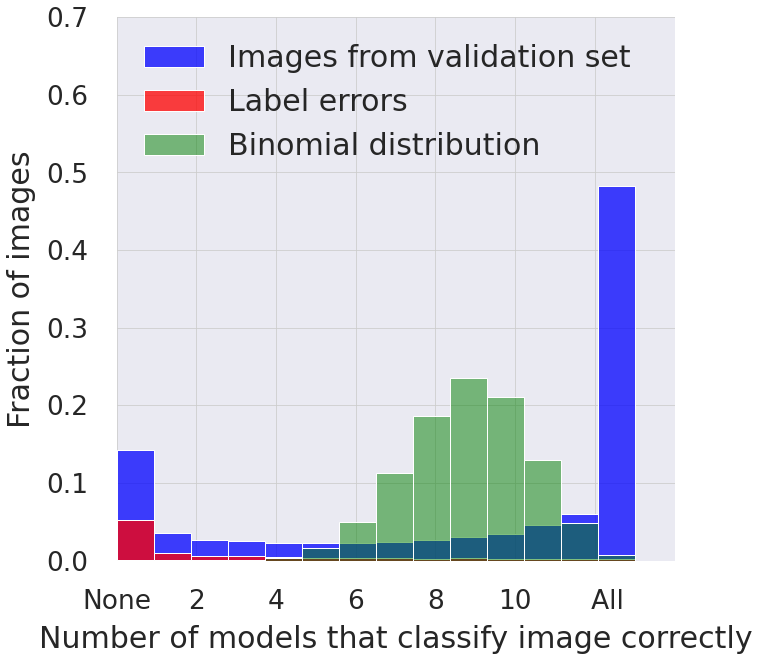

In [23]:
# Set epoch for which to make histogram
ep = 90
num_models = len(conditions)

# Make mean decisions correct with binomial observer figure
from numpy.random import default_rng
np.random.seed(1312)
rng = default_rng()
s = rng.binomial(num_models, np.mean(mean_decisions_correct[:, ep]), mean_decisions_correct.shape[0])

# Init histogram figure
plt.figure(figsize=(10,10))
sns.histplot(data=mean_decisions_correct[:, ep] * num_models, bins=num_models+1, 
             color= 'blue', label='Images from validation set', stat="probability")
    
# Plot wronly labelled images
# In order for them to have the right scale, we add the missing 45000 images at location -11
# Somehow, this slightly messes up the alignment of the bins
mean_decisions_correct_errors = mean_decisions_correct[error_inds, :].squeeze() * num_models
sns.histplot(data=np.concatenate((np.negative(np.ones(45000) * (num_models)), mean_decisions_correct_errors[:, ep])), 
             bins=num_models*2+2, color='red', label='Label errors', stat="probability")

# Adding one zero to the binomial histogram ensures that it has the same bins as the other histogram
sns.histplot(data=np.concatenate((np.zeros(1), s)), alpha=0.5, bins=num_models+1, 
             color='green', label='Binomial distribution', stat="probability")

# Plot settings
sns.set_context("paper", font_scale=3.0)
sns.set_style("white")
sns.color_palette("viridis", as_cmap=True)
sns.despine(right=True, top=True, offset=20, trim=False)
plt.xlabel("Number of models that classify image correctly", fontsize=30, labelpad=10)
plt.ylabel("Fraction of images", fontsize=30, labelpad=10)
plt.xticks(np.arange(0, num_models+1, step=2), ["None", "2", "4", "6", "8", "10", "   All"])
plt.ylim(0,0.7)
plt.xlim(0,num_models+1)

if base_network == "Res18":
    plt.legend(loc="upper left", fontsize=30, frameon=False)
plt.savefig(figure_path + 'figure_22_a.png', dpi=300, bbox_inches='tight')

## Figures 23 and 24
#### Please refer to xp_images

## Figures 25 - 28

In [24]:
# Set random seed
np.random.seed(1312)

# Load experimental result file
file_path = "./experiment2/"
file = pd.ExcelFile(file_path + "ConsistencyExperiment_2_edit.ods", engine="odf")

# Build dict from file
dfs = {ind: file.parse(sheet_name, header=None) 
          for ind, sheet_name in enumerate(file.sheet_names)}

# Pre-allocate array
arr = np.zeros((len(dfs),dfs[0].shape[0],dfs[0].shape[1]+3), dtype=float)

# Load item order and indices and model accuracy
order = np.load(file_path + "order.npy")
indices = np.int64(np.load(file_path + "indices.npy", allow_pickle=True)[6:])
mean_decisions_correct = np.load("Rebuttal_mean_decisions_correct.npy")  

# Load error indices
label_error_new = np.load("imagenet_val_ident_2.npy", allow_pickle=True)
label_error_old = np.load("imagenet_val_ident.npy", allow_pickle=True)[:, 2].astype(np.int)

# Build array from dict by looping through the sheets
for ind in range(len(dfs)):
    arr[ind,:,0:3] = dfs[ind]
    arr[ind,:,3] = order
    arr[ind,:,4] = indices
    arr[ind,:,5] = mean_decisions_correct[indices].flatten()

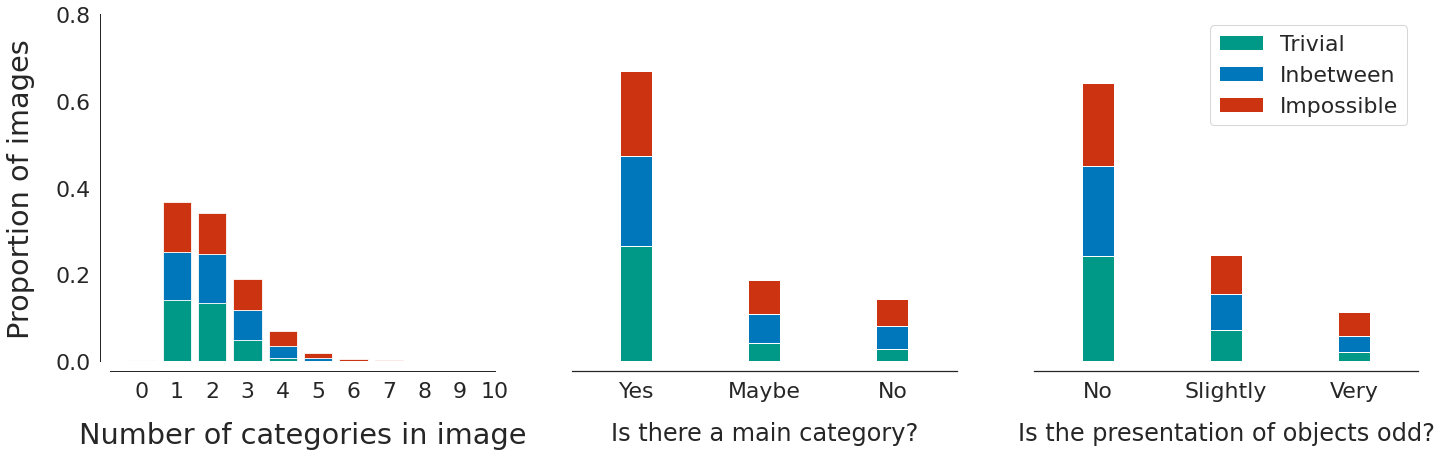

In [25]:
# Decide if you want to filter out images with label errors (we did it for Experiment 1 but not 2)
filter_errors = False # Either: False (do not filter) or True (do filter)

# Filter label errors if flag is set
if filter_errors:
    
    # Get error indices from MTURK labeled errors
    error_inds = np.where(label_error_new[indices] == 1)[0]
    
    # Remove items 44, 222, and 254 and label error indices
    arr_corrected = np.delete(arr, np.concatenate((error_inds, [43, 221, 253])), axis=1)
    
    # Make all categories have the same amount of images
    impossible_inds = np.where(arr_corrected[0,:,3] == 0)[0]
    inbetween_inds = np.where(arr_corrected[0,:,3] == 1)[0]
    trivial_inds = np.where(arr_corrected[0,:,3] == 2)[0]
    
    # Randomly pull indices which should be removed from trivials and impossibles to equal out number of images
    rm_inds_inbetween = np.random.choice(inbetween_inds, len(inbetween_inds) - len(impossible_inds), replace=False)
    rm_inds_trivial = np.random.choice(trivial_inds, len(trivial_inds) - len(impossible_inds), replace=False)
    
    # Equal out number of images for all categories
    arr_corrected = np.delete(arr_corrected, np.concatenate((rm_inds_inbetween, rm_inds_trivial)), axis=1)
    
else:
    
    # Remove items 44, 222, and 254 (indices 43, 221, 253)
    arr_corrected = np.delete(arr, [43, 221, 253], axis=1)

# Get trivial, impossible and in-between indeces
impossible_inds = np.where(arr_corrected[0,:,3] == 0)
inbetween_inds = np.where(arr_corrected[0,:,3] == 1)
trivial_inds = np.where(arr_corrected[0,:,3] == 2)

# Figure size and title
fig = plt.figure(figsize=(40,60))
counter = 1

# Loop through questions (see why shape[2]-1 in KDE plot loop above)
for question in range(3):

    # Make subplot for each question
    ax = fig.add_subplot(arr_corrected.shape[0], arr_corrected.shape[2]-1, counter)
    counter+= 1

    # Get count and label arrays
    if question == 0:
        trivial_counts, trivial_labels = np.histogram(arr_corrected[:, trivial_inds, question], 
                                                      bins=10, range=[0,10])
        inbetween_counts, inbetween_labels = np.histogram(arr_corrected[:, inbetween_inds, question], 
                                                          bins=10, range=[0,10])
        impossible_counts, impossible_labels = np.histogram(arr_corrected[:, impossible_inds, question], 
                                                            bins=10, range=[0,10])
    else:
        trivial_counts, trivial_labels = np.histogram(arr_corrected[:, trivial_inds, question], 
                                                      bins=3, range=[0,3])
        inbetween_counts, inbetween_labels = np.histogram(arr_corrected[:, inbetween_inds, question], 
                                                          bins=3, range=[0,3])
        impossible_counts, impossible_labels = np.histogram(arr_corrected[:, impossible_inds, question], 
                                                            bins=3, range=[0,3])

    # Scale bars by dividing by total image number
    total_counts = np.sum(trivial_counts) + np.sum(inbetween_counts) + np.sum(impossible_counts)
    trivial_counts = trivial_counts / total_counts
    impossible_counts = impossible_counts / total_counts
    inbetween_counts = inbetween_counts / total_counts
    
    # Make plots
    if question == 0:
        ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
               color='#009988')
        ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
               bottom=trivial_counts, color='#0077bb')
        ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
               bottom=trivial_counts+inbetween_counts, color='#cc3311')

    # Scale width of bars for questions 2 and 3
    else:
        ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
               color='#009988', width=0.25)
        ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
               bottom=trivial_counts, color='#0077bb', width=0.25)
        ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
               bottom=trivial_counts+inbetween_counts, color='#cc3311', width=0.25)

    # General settings for all plots
    sns.despine(offset=20)
    sns.set_context(context="notebook", font_scale=2)
    plt.ylim(0, 0.8)

    # Set individual x labels and limits
    if question == 0:
        plt.xticks(np.arange(0,11,1), np.arange(0,11,1), ha="center")
        plt.xlabel("Number of categories in image", labelpad=20)
        plt.ylabel("Proportion of images", labelpad=20)

    elif question == 1:
        plt.xlim(2.5,-0.5)
        plt.xticks([2,1,0], ["Yes", "Maybe", "No"])
        plt.xlabel("Is there a main category?", labelpad=20)
        y_axis = ax.axes.get_yaxis()
        y_axis.set_visible(False)
        ax.spines['left'].set_color("w")

    elif question == 2:
        plt.xlim(-0.5,2.5)
        plt.xticks([0,1,2], ["No", "Slightly", "Very"])
        plt.xlabel("Is the presentation of objects odd?", labelpad=20)
        y_axis = ax.axes.get_yaxis()
        y_axis.set_visible(False)
        ax.spines['left'].set_color("w")

    # Only show legend in upmost right plot
    if question == 2:
        plt.legend(loc="upper right")

# Figure aesthetics and saving
sns.despine(offset=10)
sns.set_context(context="notebook", font_scale=2)

# Save figure
plt.savefig(figure_path + 'figure_25.png', dpi=300, bbox_inches='tight')

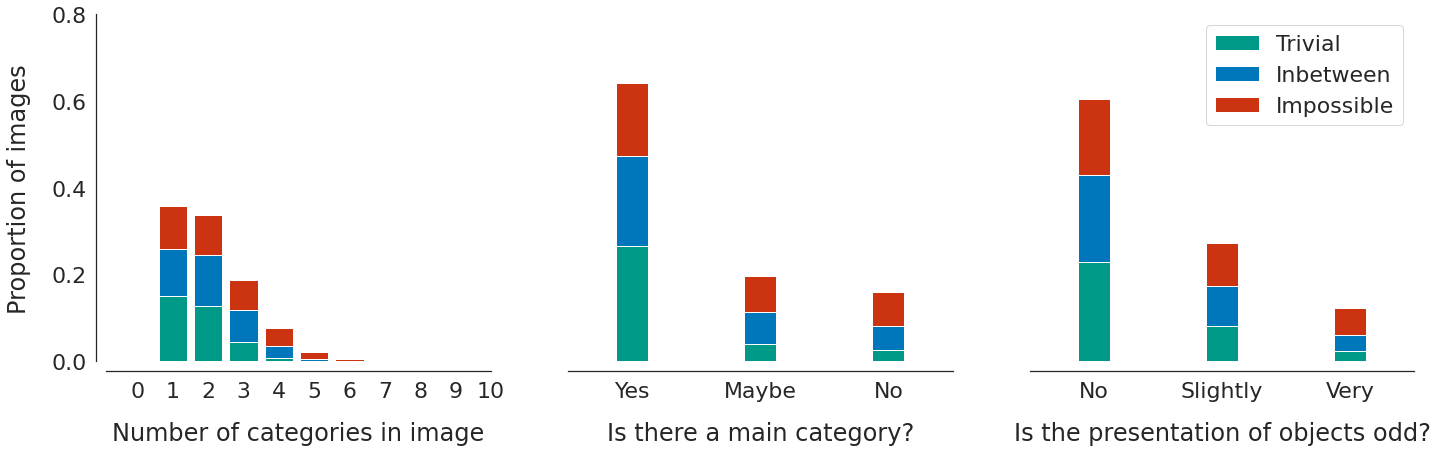

In [26]:
# Decide if you want to filter out images with label errors (we did it for Experiment 1 but not 2)
filter_errors = True # Either: False (do not filter) or True (do filter)

# Filter label errors if flag is set
if filter_errors:
    
    # Get error indices from MTURK labeled errors
    error_inds = np.where(label_error_new[indices] == 1)[0]
    
    # Remove items 44, 222, and 254 and label error indices
    arr_corrected = np.delete(arr, np.concatenate((error_inds, [43, 221, 253])), axis=1)
    
    # Make all categories have the same amount of images
    impossible_inds = np.where(arr_corrected[0,:,3] == 0)[0]
    inbetween_inds = np.where(arr_corrected[0,:,3] == 1)[0]
    trivial_inds = np.where(arr_corrected[0,:,3] == 2)[0]
    
    # Randomly pull indices which should be removed from trivials and impossibles to equal out number of images
    rm_inds_inbetween = np.random.choice(inbetween_inds, len(inbetween_inds) - len(impossible_inds), replace=False)
    rm_inds_trivial = np.random.choice(trivial_inds, len(trivial_inds) - len(impossible_inds), replace=False)
    
    # Equal out number of images for all categories
    arr_corrected = np.delete(arr_corrected, np.concatenate((rm_inds_inbetween, rm_inds_trivial)), axis=1)
    
else:
    
    # Remove items 44, 222, and 254 (indices 43, 221, 253)
    arr_corrected = np.delete(arr, [43, 221, 253], axis=1)

# Get trivial, impossible and in-between indeces
impossible_inds = np.where(arr_corrected[0,:,3] == 0)
inbetween_inds = np.where(arr_corrected[0,:,3] == 1)
trivial_inds = np.where(arr_corrected[0,:,3] == 2)

# Figure size and title
fig = plt.figure(figsize=(40,60))
counter = 1

# Loop through questions (see why shape[2]-1 in KDE plot loop above)
for question in range(3):

    # Make subplot for each question
    ax = fig.add_subplot(arr_corrected.shape[0], arr_corrected.shape[2]-1, counter)
    counter+= 1

    # Get count and label arrays
    if question == 0:
        trivial_counts, trivial_labels = np.histogram(arr_corrected[:, trivial_inds, question], 
                                                      bins=10, range=[0,10])
        inbetween_counts, inbetween_labels = np.histogram(arr_corrected[:, inbetween_inds, question], 
                                                          bins=10, range=[0,10])
        impossible_counts, impossible_labels = np.histogram(arr_corrected[:, impossible_inds, question], 
                                                            bins=10, range=[0,10])
    else:
        trivial_counts, trivial_labels = np.histogram(arr_corrected[:, trivial_inds, question], 
                                                      bins=3, range=[0,3])
        inbetween_counts, inbetween_labels = np.histogram(arr_corrected[:, inbetween_inds, question], 
                                                          bins=3, range=[0,3])
        impossible_counts, impossible_labels = np.histogram(arr_corrected[:, impossible_inds, question], 
                                                            bins=3, range=[0,3])

    # Scale bars by dividing by total image number
    total_counts = np.sum(trivial_counts) + np.sum(inbetween_counts) + np.sum(impossible_counts)
    trivial_counts = trivial_counts / total_counts
    impossible_counts = impossible_counts / total_counts
    inbetween_counts = inbetween_counts / total_counts
    
    # Make plots
    if question == 0:
        ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
               color='#009988')
        ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
               bottom=trivial_counts, color='#0077bb')
        ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
               bottom=trivial_counts+inbetween_counts, color='#cc3311')

    # Scale width of bars for questions 2 and 3
    else:
        ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
               color='#009988', width=0.25)
        ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
               bottom=trivial_counts, color='#0077bb', width=0.25)
        ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
               bottom=trivial_counts+inbetween_counts, color='#cc3311', width=0.25)

    # General settings for all plots
    sns.despine(offset=20)
    sns.set_context(context="notebook", font_scale=2)
    plt.ylim(0, 0.8)

    # Set individual x labels and limits
    if question == 0:
        plt.xticks(np.arange(0,11,1), np.arange(0,11,1), ha="center")
        plt.xlabel("Number of categories in image", labelpad=20)
        plt.ylabel("Proportion of images", labelpad=20)

    elif question == 1:
        plt.xlim(2.5,-0.5)
        plt.xticks([2,1,0], ["Yes", "Maybe", "No"])
        plt.xlabel("Is there a main category?", labelpad=20)
        y_axis = ax.axes.get_yaxis()
        y_axis.set_visible(False)
        ax.spines['left'].set_color("w")

    elif question == 2:
        plt.xlim(-0.5,2.5)
        plt.xticks([0,1,2], ["No", "Slightly", "Very"])
        plt.xlabel("Is the presentation of objects odd?", labelpad=20)
        y_axis = ax.axes.get_yaxis()
        y_axis.set_visible(False)
        ax.spines['left'].set_color("w")

    # Only show legend in upmost right plot
    if question == 2:
        plt.legend(loc="upper right")

# Figure aesthetics and saving
sns.despine(offset=10)
sns.set_context(context="notebook", font_scale=2)

# Save figure
plt.savefig(figure_path + 'figure_26.png', dpi=300, bbox_inches='tight')

Observer: 0
Observer: 1
Observer: 2
Observer: 3
Observer: 4
Observer: 5
Observer: 6
Observer: 7


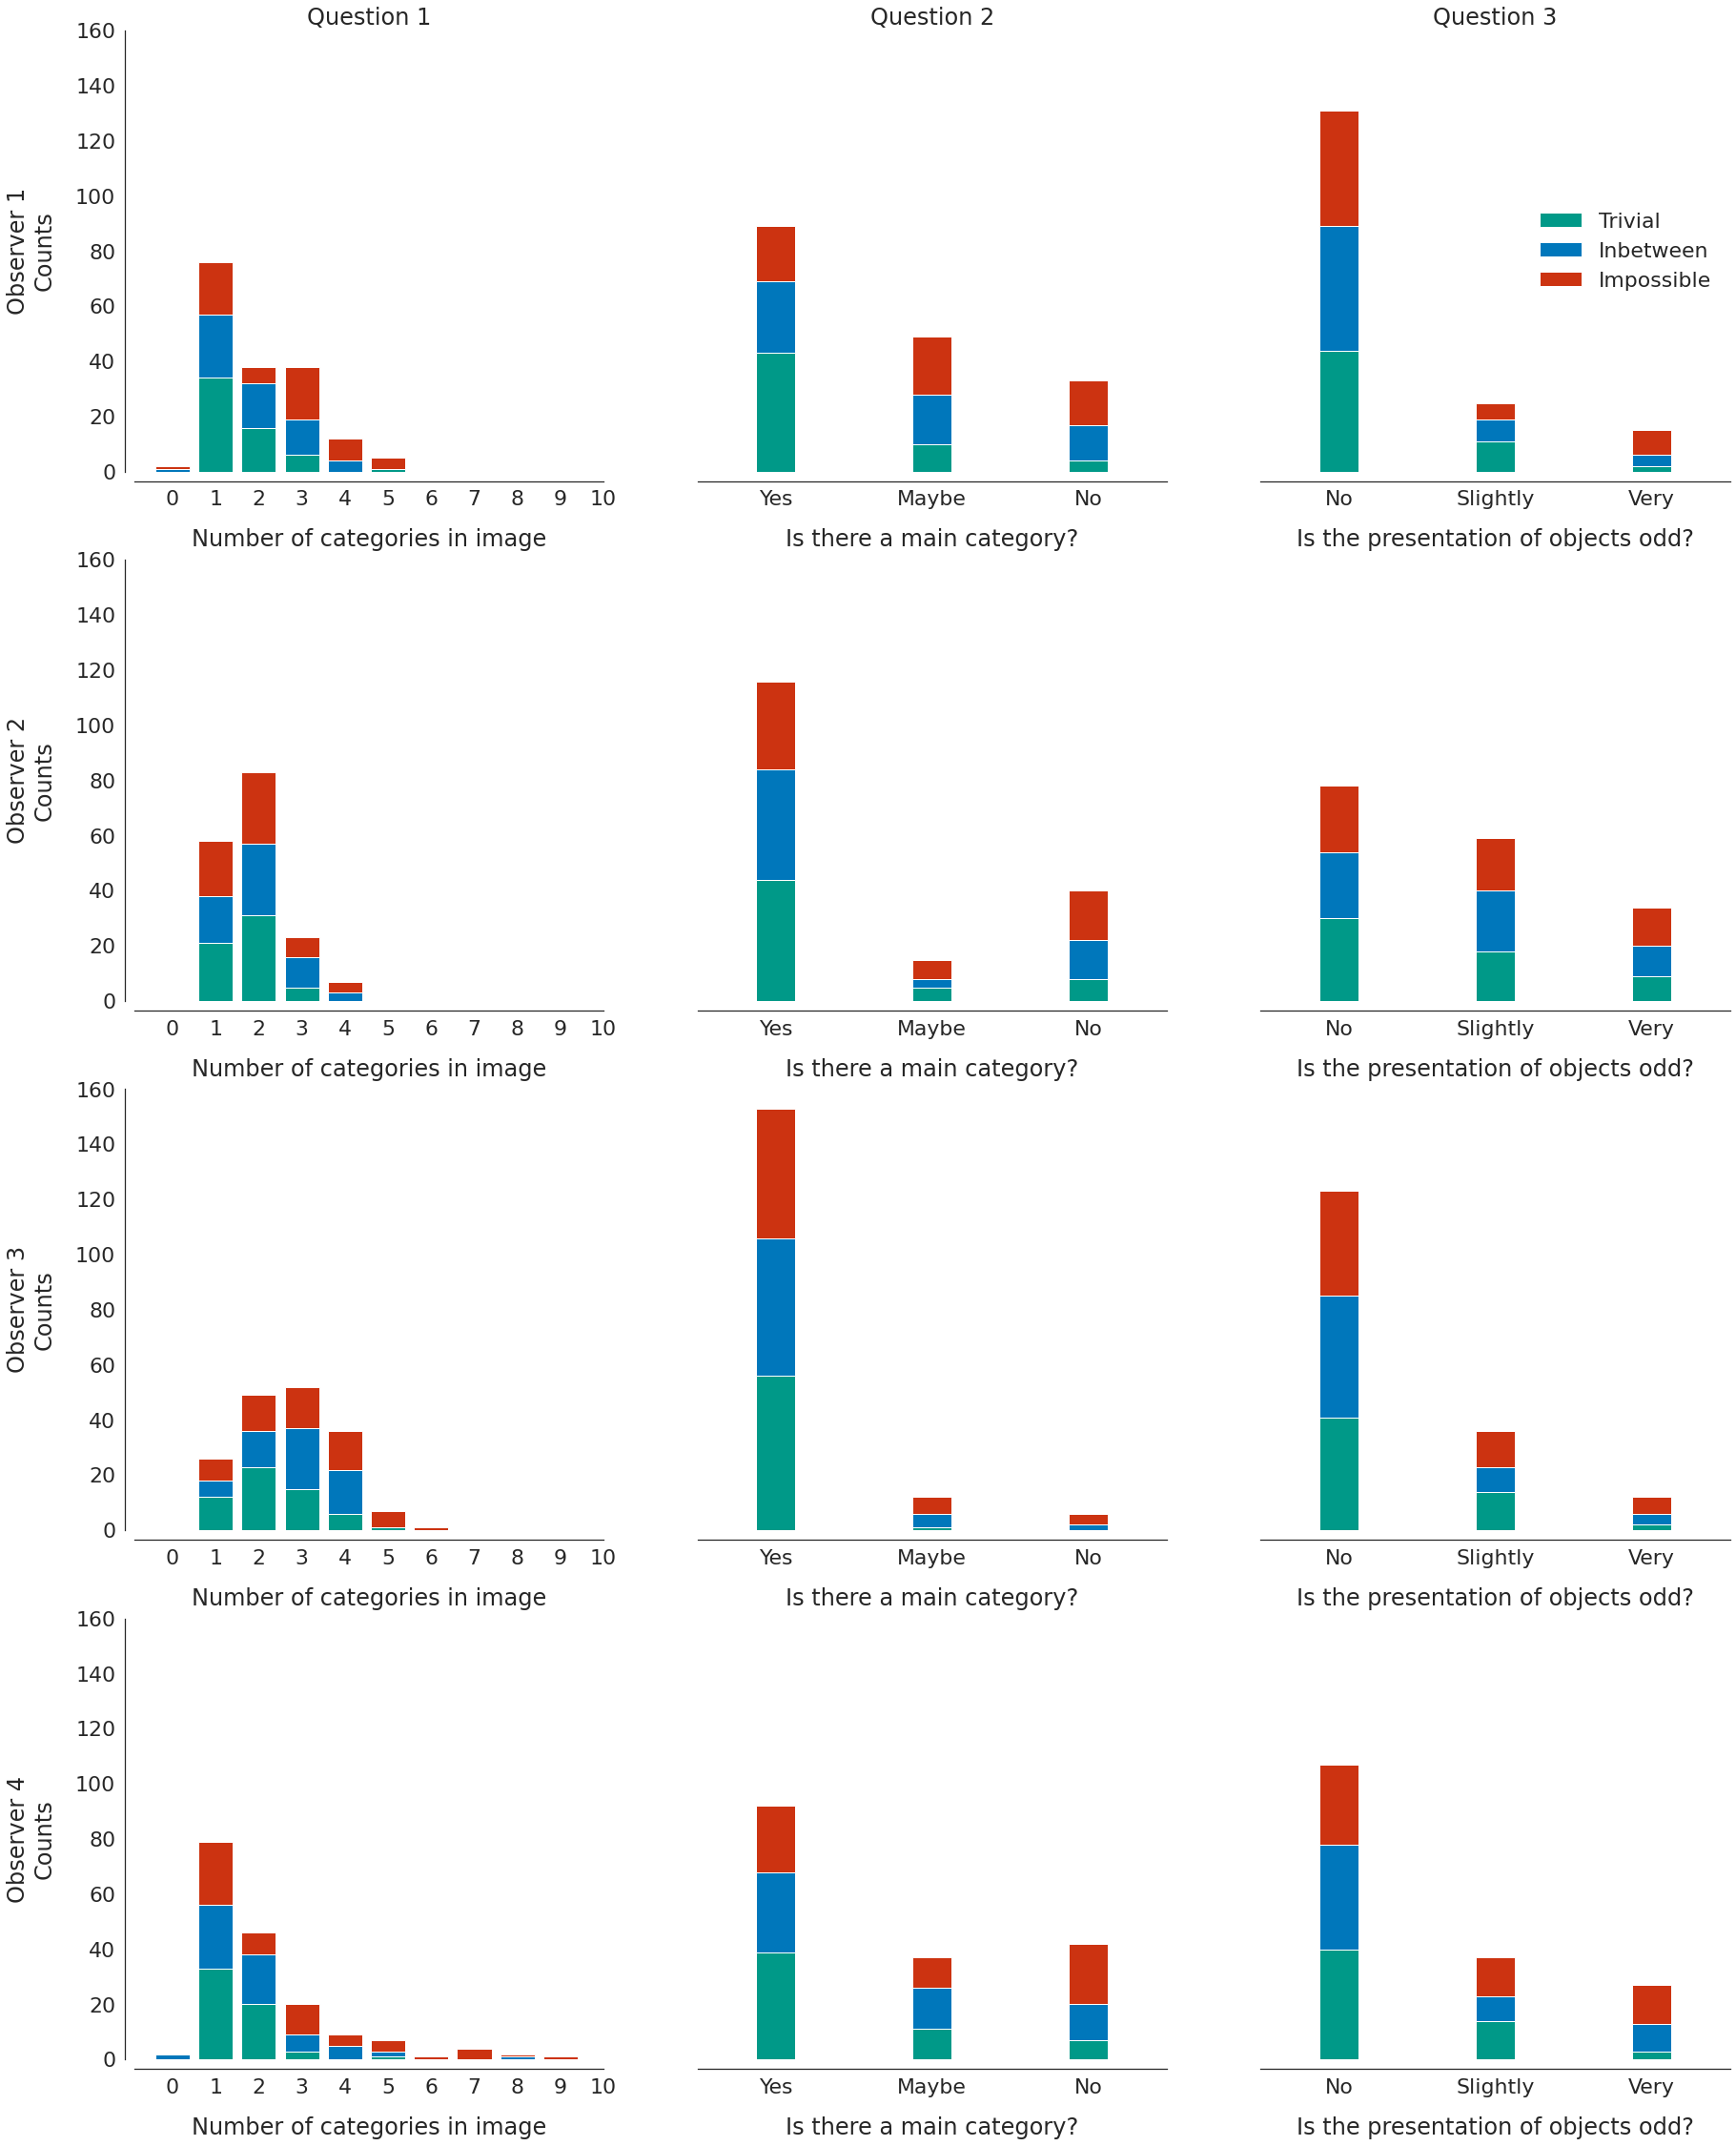

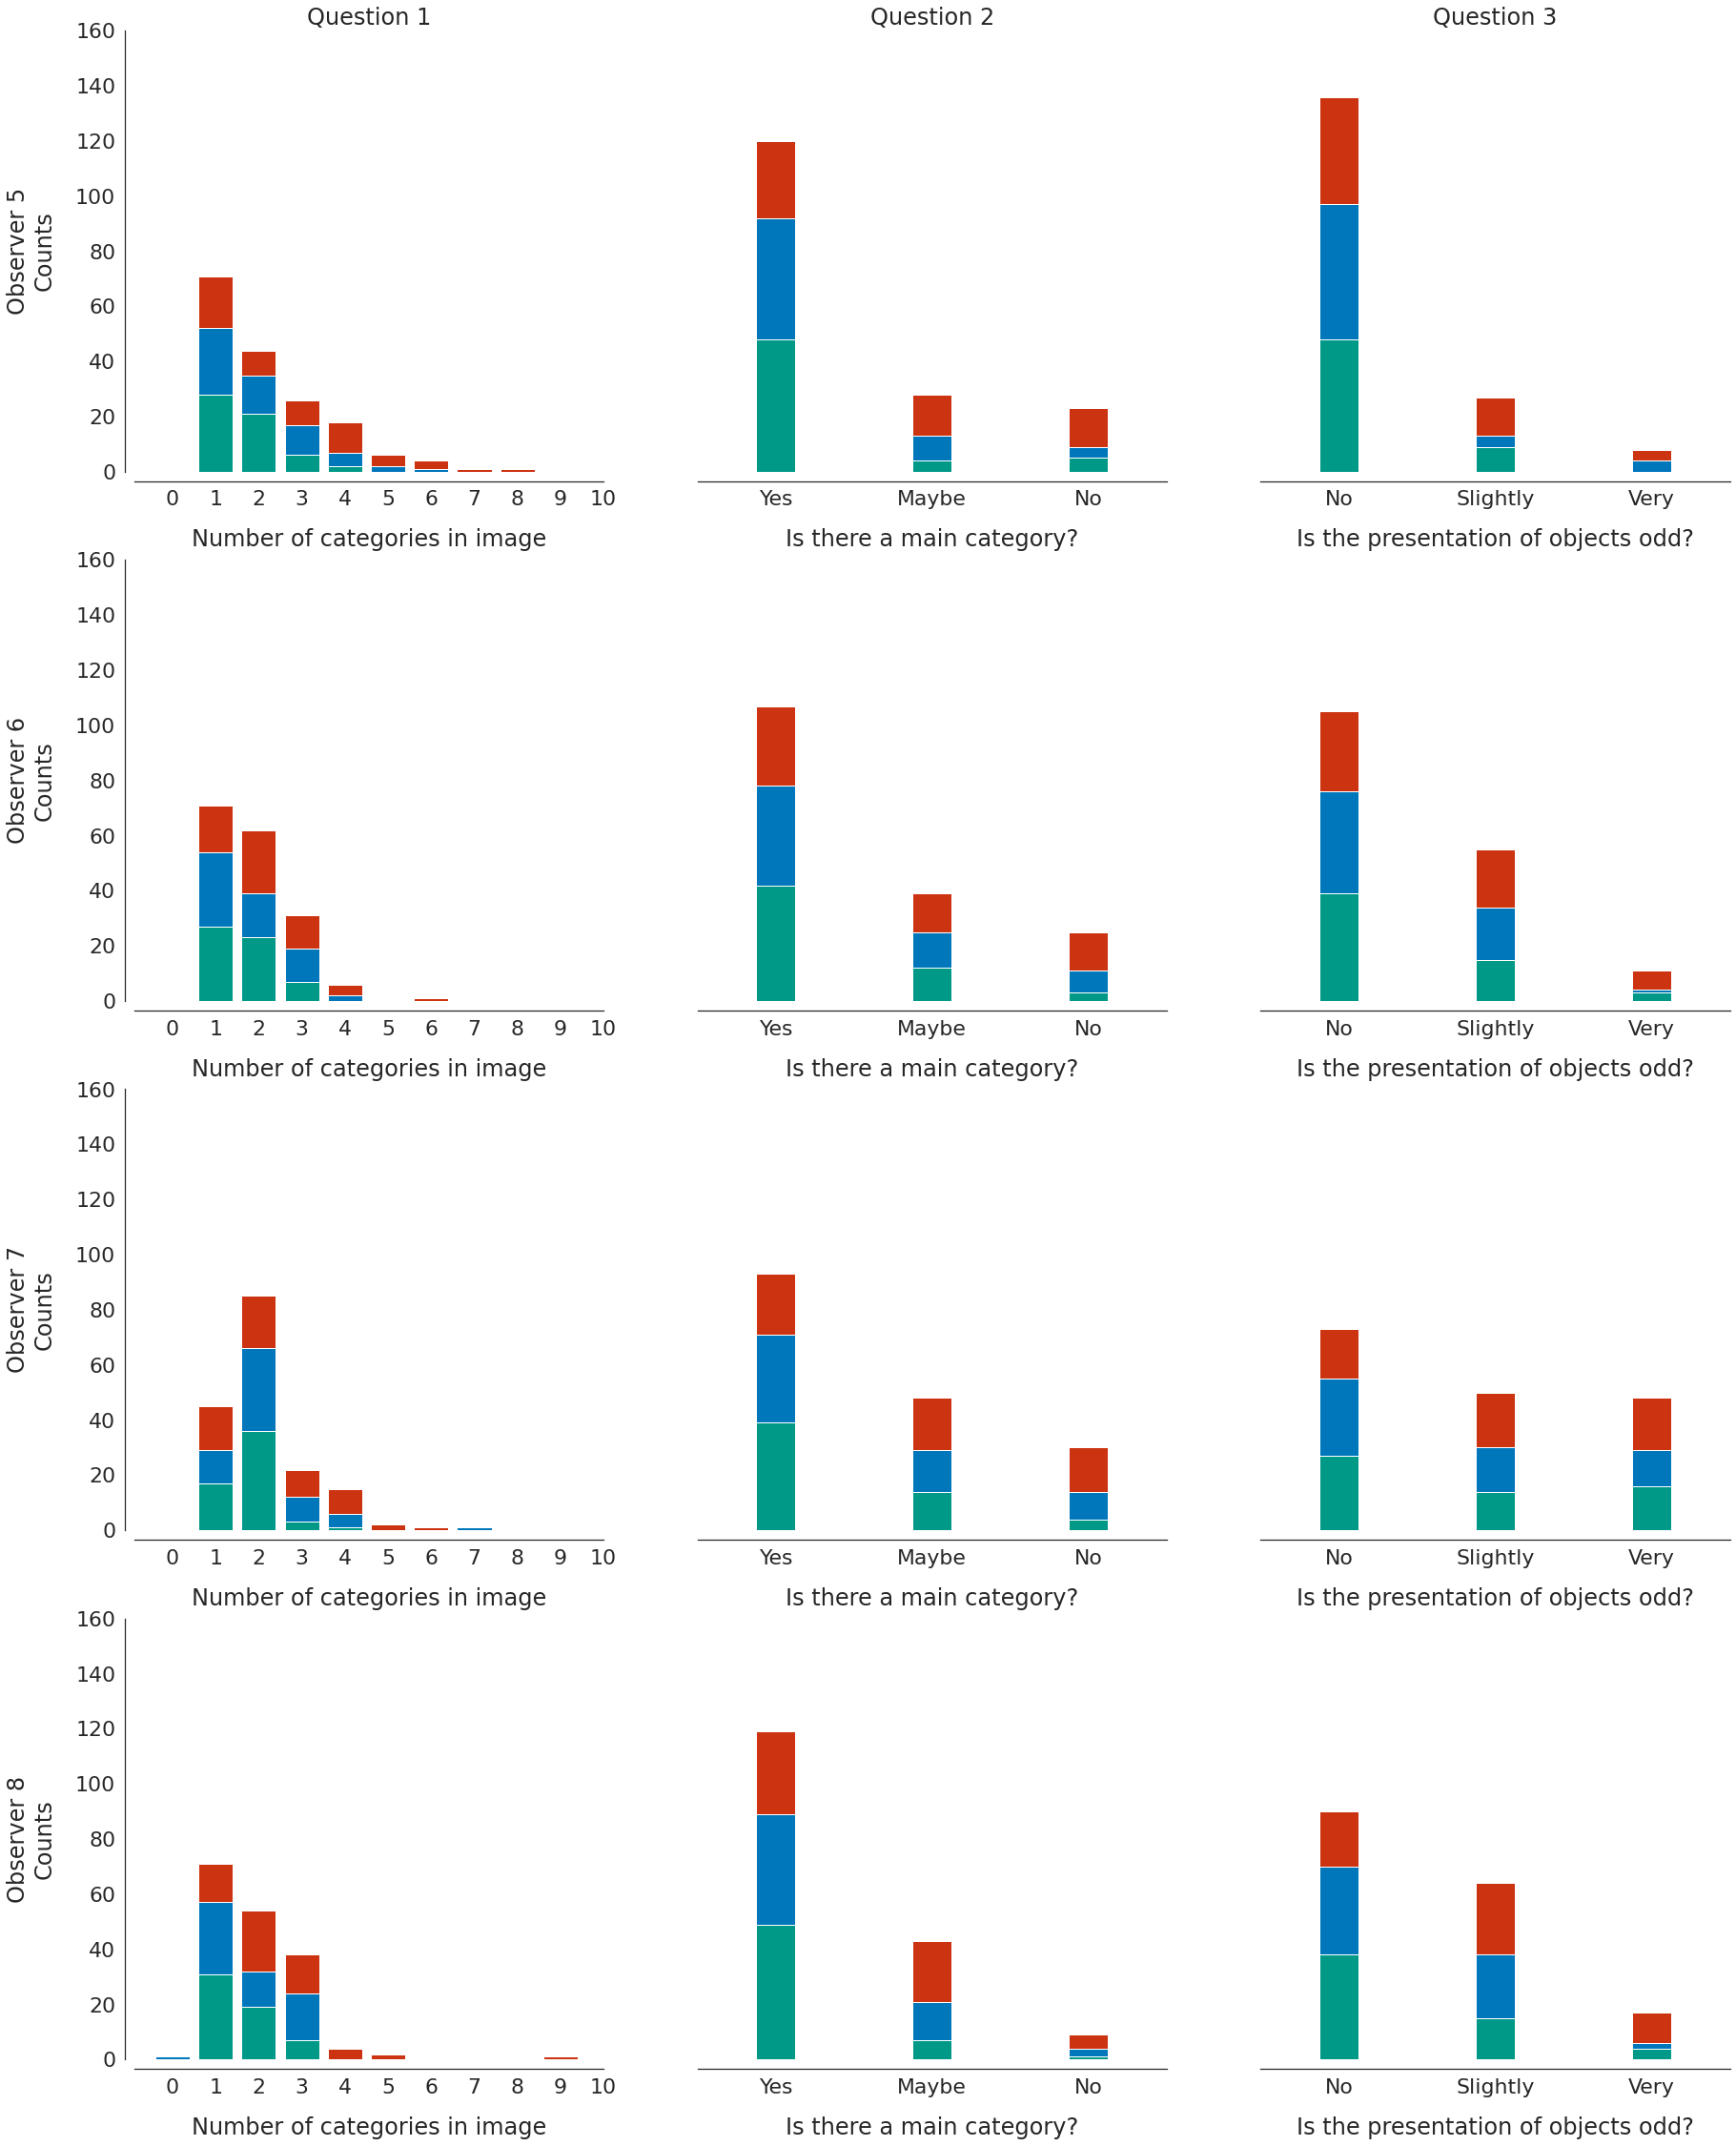

In [27]:
# Decide if you want to filter out images with label errors (we did it for Experiment 1 but not 2)
filter_errors = True # Either: False (do not filter) or True (do filter)

# Filter label errors if flag is set
if filter_errors:
    
    # Get error indices from MTURK labeled errors
    error_inds = np.where(label_error_new[indices] == 1)[0]
    
    # Remove items 44, 222, and 254 and label error indices
    arr_corrected = np.delete(arr, np.concatenate((error_inds, [43, 221, 253])), axis=1)
    
    # Make all categories have the same amount of images
    impossible_inds = np.where(arr_corrected[0,:,3] == 0)[0]
    inbetween_inds = np.where(arr_corrected[0,:,3] == 1)[0]
    trivial_inds = np.where(arr_corrected[0,:,3] == 2)[0]
    
    # Randomly pull indices which should be removed from trivials and impossibles to equal out number of images
    rm_inds_inbetween = np.random.choice(inbetween_inds, len(inbetween_inds) - len(impossible_inds), replace=False)
    rm_inds_trivial = np.random.choice(trivial_inds, len(trivial_inds) - len(impossible_inds), replace=False)
    
    # Equal out number of images for all categories
    arr_corrected = np.delete(arr_corrected, np.concatenate((rm_inds_inbetween, rm_inds_trivial)), axis=1)
    
else:
    
    # Remove items 44, 222, and 254 (indices 43, 221, 253)
    arr_corrected = np.delete(arr, [43, 221, 253], axis=1)

# Get trivial, impossible and in-between indeces
impossible_inds = np.where(arr_corrected[0,:,3] == 0)
inbetween_inds = np.where(arr_corrected[0,:,3] == 1)
trivial_inds = np.where(arr_corrected[0,:,3] == 2)

# Divide image in 2
for part in [0,1]:
               
    # Init figure and question counter
    fig = plt.figure(figsize=(30,80))
    counter = 1
    
    # For each observer make a histogram for each question
    for observer in np.arange((arr_corrected.shape[0]/2)*(part),(arr_corrected.shape[0]/2)*(part+1),dtype=int):


        # Print observer and clear plot 
        print(f"Observer: {observer}")

        # Loop through questions (see why -1 in loop for KDE plot above)
        for question in range(3):

            # Make subplot for each question
            ax = fig.add_subplot(arr_corrected.shape[0], 3, counter)
            counter+= 1

            # Get count and label arrays
            if question == 0:
                trivial_counts, trivial_labels = np.histogram(arr_corrected[observer, trivial_inds, question], 
                                                              bins=10, range=[0,10])
                inbetween_counts, inbetween_labels = np.histogram(arr_corrected[observer, inbetween_inds, question], 
                                                                  bins=10, range=[0,10])
                impossible_counts, impossible_labels = np.histogram(arr_corrected[observer, impossible_inds, question], 
                                                                    bins=10, range=[0,10])
            else:
                trivial_counts, trivial_labels = np.histogram(arr_corrected[observer, trivial_inds, question], 
                                                              bins=3, range=[0,3])
                inbetween_counts, inbetween_labels = np.histogram(arr_corrected[observer, inbetween_inds, question], 
                                                                  bins=3, range=[0,3])
                impossible_counts, impossible_labels = np.histogram(arr_corrected[observer, impossible_inds, question], 
                                                                    bins=3, range=[0,3])

            # Make plots
            if question == 0:
                ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
                       color='#009988')
                ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
                       bottom=trivial_counts, color='#0077bb')
                ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
                       bottom=trivial_counts+inbetween_counts, color='#cc3311')

            # Scale width of bars for questions 2 and 3
            else:
                ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
                       color='#009988', width=0.25)
                ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
                       bottom=trivial_counts, color='#0077bb', width=0.25)
                ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
                       bottom=trivial_counts+inbetween_counts, color='#cc3311', width=0.25)

            # General settings for all plots
            sns.despine(offset=20)
            sns.set_context(context="notebook", font_scale=2)

            # Different y limits for filtered plot, since the counts are roughly halved
            if filter_errors:
                plt.ylim(0, 160)
            else:
                plt.ylim(0, 300)

            # Set individual x labels and limits
            if question == 0:
                plt.xticks(np.arange(0,11,1), np.arange(0,11,1), ha="center")
                plt.xlabel("Number of categories in image", labelpad=20)
                plt.ylabel(f"Observer {observer+1}\nCounts", labelpad=20)

            elif question == 1:
                plt.xlim(2.5,-0.5)
                plt.xticks([2,1,0], ["Yes", "Maybe", "No"])
                plt.xlabel("Is there a main category?", labelpad=20)
                y_axis = ax.axes.get_yaxis()
                y_axis.set_visible(False)
                ax.spines['left'].set_color("w")

            elif question == 2:
                plt.xlim(-0.5,2.5)
                plt.xticks([0,1,2], ["No", "Slightly", "Very"])
                plt.xlabel("Is the presentation of objects odd?", labelpad=20)
                y_axis = ax.axes.get_yaxis()
                y_axis.set_visible(False)
                ax.spines['left'].set_color("w")

            # Only show legend in upmost right plot
            if question == 2 and observer == 0:
                plt.legend(loc="center right", frameon=False)

            # Only plot question index above first row of plots
            if observer == 0 or observer == 4:
                plt.title(f"Question {question+1}")

        # Figure aesthetics
        sns.despine(offset=10)
        sns.set_context(context="notebook", font_scale=2)

    # Save figure
    # Save figure
    plt.savefig(figure_path + f'figure_{27+part}.png', dpi=300, bbox_inches='tight')